# Debug IDEA 10 M

Weeeelll, somthing is wrong, so let's compare the data quickly. 


**Conclusion**: Comparing FastSim IDEA 2M and 10 M dataset that I have created on Hss, everything seems fine! Same for comparing with the dataset from `samples_v2` Michele created for Dolores back then. 


In [1]:
save_status = False # save all histograms!

In [2]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [3]:
# to not change every variable in this code, fast sim refers to 2 M dataset, full sim to 10 M dataset

# also run this notebook for `samples_v2` data... as full sim

#path_fullsim = "/eos/experiment/fcc/ee/jet_flavour_tagging/winter2023/fastsim_2mio_total_SaraTagging/IDEA/training_10M/Hss.root"
path_fullsim = "/eos/experiment/fcc/ee/jet_flavour_tagging/winter2023/samples_v2/stage2_Hss.root"
path_fastsim = "/eos/experiment/fcc/ee/jet_flavour_tagging/winter2023/fastsim_2mio_total_SaraTagging/IDEA/training/Hss.root"

file_fu = uproot.open(path_fullsim)
tree_fu = file_fu["tree;1"]

file_fa = uproot.open(path_fastsim)
tree_fa = file_fa["tree;1"]

In [4]:
df_fa = tree_fa.arrays(library="np", entry_start=0, entry_stop=10000) #entry_start=0, entry_stop=200, 
df_fu = tree_fu.arrays(library="np", entry_start=0, entry_stop=10000)

In [5]:
def histograms(keys, n, k, figsize=(13, 2), bins=50, conc=False, save=False, path=None):
    fig, axs = plt.subplots(n, k, figsize=figsize)
    
    for i, ax in enumerate(axs.flat):
        ax.set_title(keys[i])
        ax.grid()
        # set same range if not specified
        try:
            fa = df_fa[keys[i]]
            fu = df_fu[keys[i]]
            combined_min = min(fa.min(), fu.min())
            combined_max = max(fa.max(), fu.max())
            combined_range = (combined_min, combined_max)
        except ValueError:
            fa = np.concatenate(df_fa[keys[i]])
            fu = np.concatenate(df_fu[keys[i]])
            combined_min = min(fa.min(), fu.min())
            combined_max = max(fa.max(), fu.max())
            combined_range = (combined_min, combined_max)
        # plot
        if conc==False:
            ax.hist(df_fa[keys[i]], bins=bins, range=combined_range, label='FastSim', histtype='step', linewidth=2.0, density=True) # set density=True to normalize
            ax.hist(df_fu[keys[i]], bins=bins, range=combined_range, label='FullSim', histtype='step', linewidth=2.0, density=True)
        else: 
            ax.hist(np.concatenate(df_fa[keys[i]]), bins=bins, range=combined_range, histtype='step', linewidth=2.0, label='FastSim', density=True) # set density=True to normalize
            ax.hist(np.concatenate(df_fu[keys[i]]), bins=bins, range=combined_range, histtype='step', linewidth=2.0, label='FullSim', density=True)
    
    plt.legend()
    plt.tight_layout()
    if save:
        if path==None:
            path = './hist/histogram.pdf'
        plt.savefig(path)

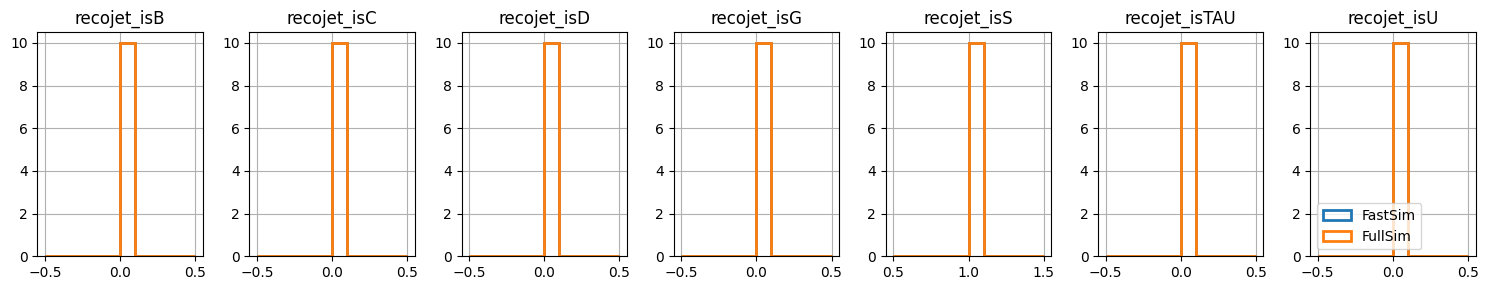

In [6]:
keys = ['recojet_isB',
 'recojet_isC',
 'recojet_isD',
 'recojet_isG',
 'recojet_isS',
 'recojet_isTAU',
 'recojet_isU']

histograms(keys, 1, 7, figsize=(15, 3), bins=10)

**Conclusion**: we see that in the full sim the reco PID of the quark is wrong! Although we have only b jets it classifies very jet as c ...

Well... not sure that goes wrong here. I definitely use b quarks for fullsim, why is it marked as c? I double checked the PDG IDs.

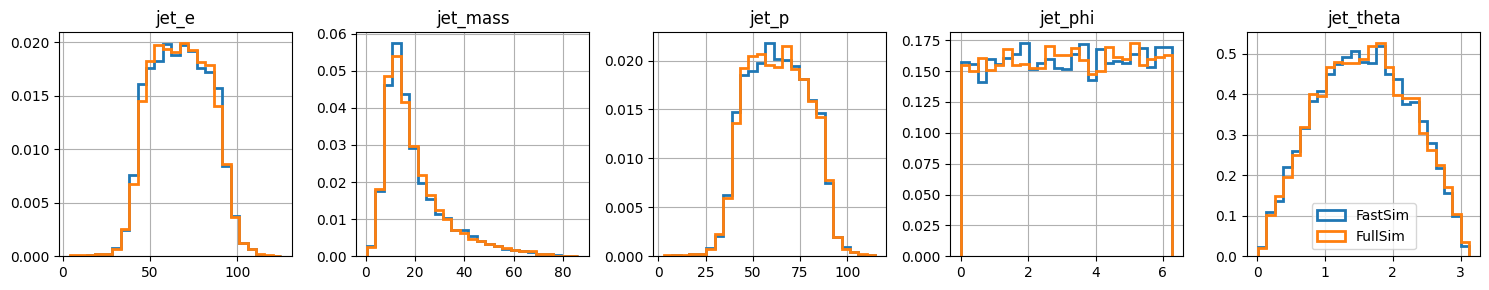

In [7]:
keys = ['jet_e',
 'jet_mass',
 'jet_p',
 'jet_phi',
 'jet_theta']


histograms(keys, 1, 5, figsize=(15, 3), bins=25, save=save_status, path='./hist/jet_properties.pdf')

- `jet_e` seems fine
- `jet_mass` seems fine
- `jet_p` seems fine
- `jet_phi` seems fine -> only other range! $\phi_{\mathrm{FullSim}} \in [-\pi, \pi]$ but $\phi_{\mathrm{FastSim}} \in [0, 2\pi]$
- `jet_theta` seems fine


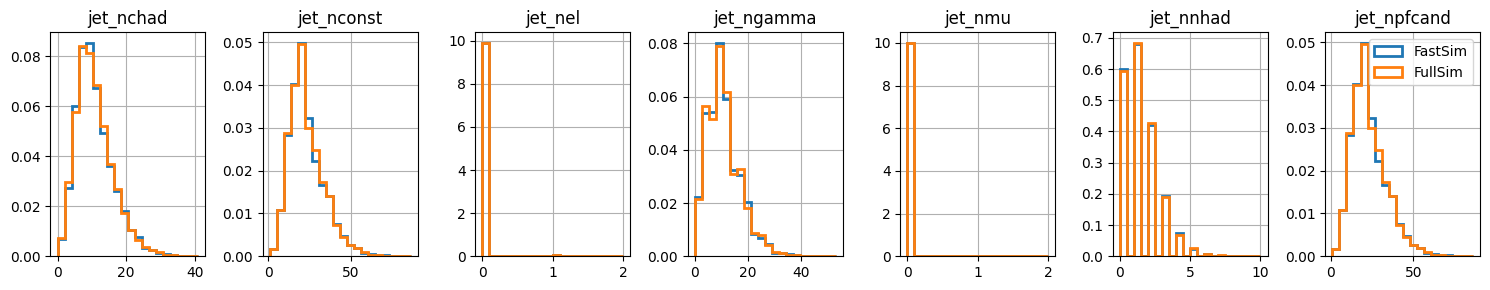

In [8]:
keys = ['jet_nchad',
 'jet_nconst',
 'jet_nel',
 'jet_ngamma',
 'jet_nmu',
 'jet_nnhad',
 'jet_npfcand']

histograms(keys, 1, 7, figsize=(15, 3), bins=20, save=save_status, path='./hist/jet_multiplicities.pdf')

Reasonable enough?
-> more neutral hadrons than with fast sim... this should be fine as full sim just includes more "trash"

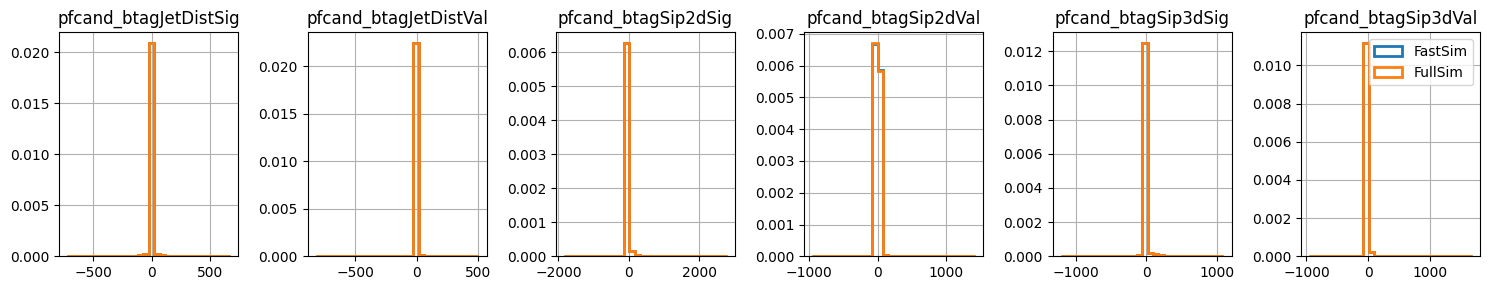

In [9]:
keys = ['pfcand_btagJetDistSig',
 'pfcand_btagJetDistVal',
 'pfcand_btagSip2dSig',
 'pfcand_btagSip2dVal',
 'pfcand_btagSip3dSig',
 'pfcand_btagSip3dVal']

histograms(keys, 1, 6, figsize=(15, 3), bins=30, conc=True)

Okay, Michele said that I should always compare the particles in a jet with the highest amount of energy and not the whole distribution because it might differ in the tails. So let's do that instead:

In [10]:
def get_index_highest_energy_particle(df, k=3):
    l = 0
    try:
        if df == 'fa':
            particles_e = df_fa['pfcand_e']
        elif df == 'fu':
            particles_e = df_fu['pfcand_e']
        index = np.zeros((particles_e.shape[0], k), dtype=int)
        for i  in range(particles_e.shape[0]):
            part_e = particles_e[i]
            ind = np.argpartition(part_e, -k)[-k:]
            ind = ind[np.argsort(part_e[ind])[::-1]]
            index[i] = ind
    except ValueError:
        l += 1
        if df == 'fa':
            particles_e = df_fa['pfcand_e']
        elif df == 'fu':
            particles_e = df_fu['pfcand_e']
        index = np.zeros((particles_e.shape[0], k), dtype=int)
        print("particle shape", particles_e.shape[0])
    print("l", l)
    return index

In [11]:
index_fa = get_index_highest_energy_particle("fa")
index_fu = get_index_highest_energy_particle("fu")

particle shape 10000
l 1
particle shape 10000
l 1


In [12]:
# Access the desired elements
def get_elements(df_value, index):
    return np.array([df_value[i][index[i]] for i in range(len(df_value))])


There are so many outliner, quite hard to compare...

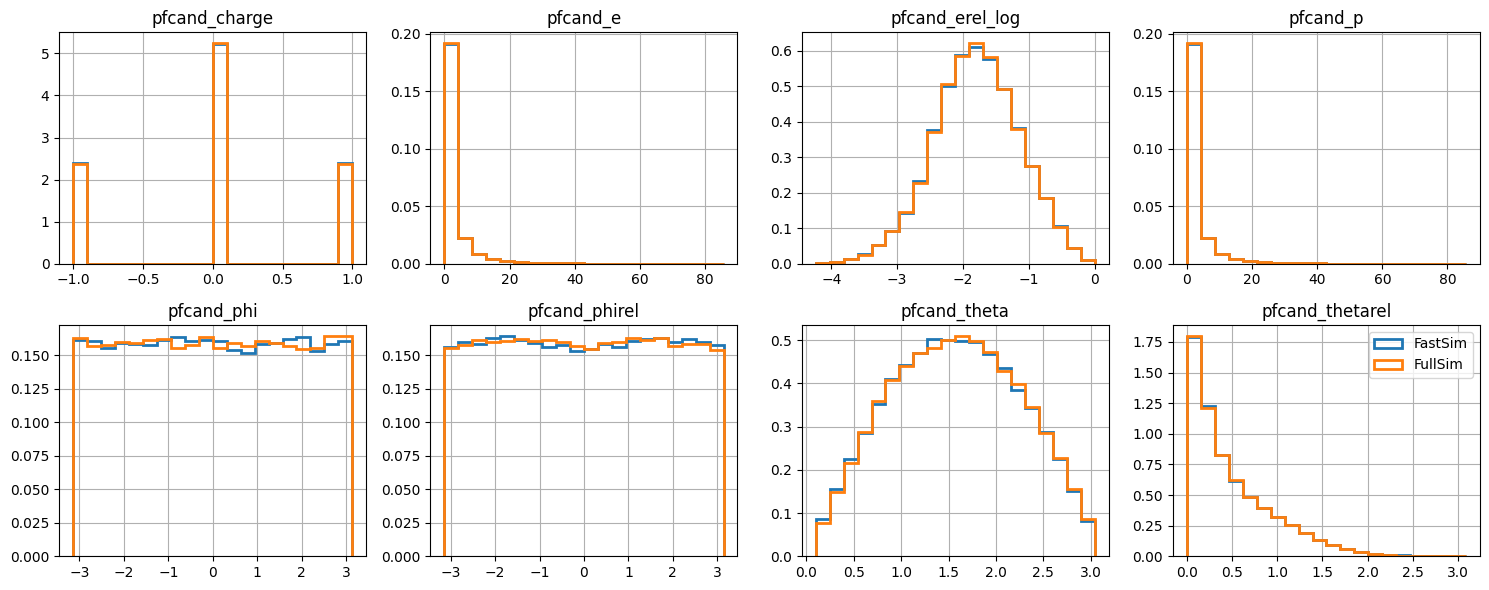

In [13]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

histograms(keys, 2, 4, figsize=(15, 6), bins=20, conc=True)

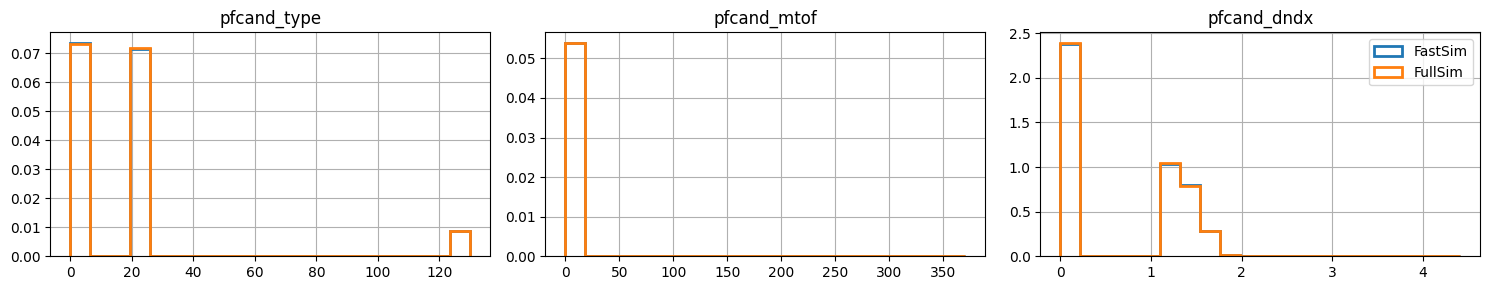

In [14]:
keys = ['pfcand_type', 'pfcand_mtof', 'pfcand_dndx']

histograms(keys, 1, 3, figsize=(15, 3), bins=20, conc=True)

In [17]:
from collections import defaultdict

In [18]:
def count_values(arrays, flatten=True):
    count_dict = defaultdict(int)
    
    # Flatten the array of arrays
    if flatten:
        flattened = np.concatenate(arrays)
    else:
        flattened = arrays
    
    # Count each value in the flattened array
    for value in flattened:
        count_dict[value] += 1
    
    return dict(count_dict)

In [19]:
count_values(df_fa['pfcand_type'])

{np.float32(0.0): 110095, np.float32(22.0): 107209, np.float32(130.0): 12863}

0 means charged (electrons, myons, charged hadrons)

22 photons

130 neutral hadrons

In [20]:
count_values(df_fu['pfcand_type'])

{np.float32(0.0): 109964, np.float32(130.0): 12829, np.float32(22.0): 108070}

In [21]:
np.sum(df_fu['jet_nnhad']) #543

np.float32(12829.0)

In [22]:
np.sum(df_fu['jet_nchad']) #883 + 896 = 1779 check

np.float32(109807.0)

### Let's calculate some purity for FullSim

We have `pfcand_type` which is reco PID and we have `pfcand_MCPID` which is MC truth. Let's check how often they match.

In [23]:
count_values(df_fu['pfcand_MCPID'])

KeyError: 'pfcand_MCPID'

In [24]:
translation = {321: 211,-321: -211, 130:2112, -2112: 2112, 2212: 211, -2212: -211, 3222: 211, 3122: 2112}

mcPID = np.concatenate(df_fu['pfcand_MCPID'])
recoPID = np.concatenate(df_fu['pfcand_type'])

# Vectorized translation function
translate = np.vectorize(lambda x: translation.get(x, x))
mcPID= translate(mcPID)

KeyError: 'pfcand_MCPID'

In [15]:

# Function to calculate overall similarity
def calculate_similarity(mcPID, recoPID):
    if len(mcPID) != len(recoPID):
        raise ValueError("Arrays must be of the same length")
    
    # Calculate overall similarity
    overall_similarity = np.sum(mcPID == recoPID) / len(mcPID) * 100

    # Calculate similarity for each unique number
    unique_numbers = np.unique(mcPID)
    similarity_per_number = {}
    
    for number in unique_numbers:
        mc_indices = mcPID == number
        reco_indices = recoPID == number
        similarity_per_number[number] = np.sum(mc_indices & reco_indices) / np.sum(mc_indices) * 100

    return overall_similarity, similarity_per_number

# Calculate similarities
overall_similarity, similarity_per_number = calculate_similarity(mcPID, recoPID)

print(f"Overall purity: {overall_similarity:.2f}%")
print("Purity per PID:")
for number, similarity in similarity_per_number.items():
    if number!=-999:
        print(f"{number}: {similarity:.2f}%")

NameError: name 'mcPID' is not defined

In [26]:
from collections import Counter

def find_normalized_confusions(mcPID, recoPID):
    if len(mcPID) != len(recoPID):
        raise ValueError("Arrays must be of the same length")

    unique_numbers = np.unique(mcPID)
    confusion_dict = {}

    for number in unique_numbers:
        mismatched_indices = (mcPID == number) & (mcPID != recoPID)
        mismatched_reco = recoPID[mismatched_indices]
        
        if mismatched_reco.size > 0:
            confusion_counts = Counter(mismatched_reco)
            total_confusions = sum(confusion_counts.values())
            normalized_confusions = {k: round(v / total_confusions, 3) for k, v in confusion_counts.items()}
            confusion_dict[number] = sorted(normalized_confusions.items(), key=lambda item: item[1], reverse=True)
        else:
            confusion_dict[number] = []

    return confusion_dict

# Find normalized confusions
normalized_confusions = find_normalized_confusions(mcPID, recoPID)

print("Normalized confusions for each particle:")
for particle, confusions_list in normalized_confusions.items():
    print(f"mcPID {particle} is confused with: {confusions_list}")

NameError: name 'mcPID' is not defined

## Open questions
- keys (three more in fullsim - we need them?)
- how to check if tree structure is the same?
- `recojet_isX` is wrong - how to deal with that?
- which values are MC and with one reconstructed?
- SIP sig values:-9 doesn't make sense
- covariance values ok?
- `pfcand_anglerel` are off - why?
- `pfcand_type`: different values and handle 0?

# Plots for charged particles and neutral particles

I would like to redo some plots, showing them for charged (neutral) particles only. 

First, let's get the indices of the highest energetic particles which are also charged:

In [16]:
def get_index_charged_particles(df, ptype='cpart'):
    """Choose particle type: cpart, npart, photon"""
    if df == 'fa':
        types = df_fa['pfcand_type']
    elif df == 'fu':
        types = df_fu['pfcand_type']
    if ptype=='cpart':
        num = [0]
    elif ptype=='npart':
        num = [130]
    elif ptype=='photon':
        num = [22]
    mask_bool_chad = []
    for i in range(types.shape[0]):
        index = np.where(np.isin(types[i], num))[0]
        bool_list = np.zeros(len(types[i]), dtype=bool)
        bool_list[index] = True
        mask_bool_chad.append(bool_list)
    return mask_bool_chad

In [17]:
def get_value_highest_energy_particle(df, k=3, ptype='cpart', debug=False):
    """return the index of the k highest energy charged particle in each event"""
    if df == 'fa':
        particles_e = df_fa['pfcand_e']
        mask_chad = get_index_charged_particles('fa', ptype=ptype)
    elif df == 'fu':
        particles_e = df_fu['pfcand_e']
        mask_chad = get_index_charged_particles('fu', ptype=ptype)
    index_charged = []
    for i  in range(particles_e.shape[0]):
        part_e = particles_e[i]
        ind = np.argsort(part_e)[::-1]
        mask = mask_chad[i]
        c_index = np.arange(len(part_e))[mask] # indicies with charged/neutral particles
        # now order the charged/neutral particles by energy with ind
        index_map = {value: np.where(ind == value)[0][0] for value in c_index}
        sorted_c_index = sorted(c_index, key=lambda x: index_map[x])
        index_charged.append(sorted_c_index[:k])
        if debug and i==1:
            print("part_e: ", part_e)
            print("mask: ", mask)
            print("ind: ", ind)
            print("index_map: ", index_map)
            print("c_index: ", c_index)
            print("sorted_c_index: ", sorted_c_index)
    return index_charged

In [18]:
# these are lists because there might not always be 3 charged particles
index_charged_3E_fu = get_value_highest_energy_particle("fu")
index_charged_3E_fa = get_value_highest_energy_particle("fa")
# these are lists because there might not always be 3 neutral particles
index_neutral_3E_fu = get_value_highest_energy_particle("fu", ptype='npart')
index_neutral_3E_fa = get_value_highest_energy_particle("fa", ptype='npart')
# these are lists because there might not always be 3 photons
index_photon_3E_fu = get_value_highest_energy_particle("fu", ptype='photon')
index_photon_3E_fa = get_value_highest_energy_particle("fa", ptype='photon')

Now, let's get the values for key and make a function to plot them.

In [19]:
def get_chad_elements(df_value, index):
    e_1 = []
    e_2 = []
    e_3 = []
    for i in range(len(df_value)):
        index_list = index[i] # this can have 1, 2 or 3 elements
        if len(index_list) == 1:
            e_1.append(df_value[i][index_list[0]])
        elif len(index_list) == 2:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
        elif len(index_list) == 3:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
            e_3.append(df_value[i][index_list[2]])
    return [np.array(e_1), np.array(e_2), np.array(e_3)]

In [20]:
def plot_key_highest_e_cpart(keys, k=3, r=None, bins=20, log=False, save=False, path=None):
    fig, axs = plt.subplots(len(keys), k, figsize=(15, 3 * len(keys))) 

    # loop over keys: 
    for idx, key in enumerate(keys):
        a_list = get_chad_elements(df_fa[key], index_charged_3E_fa)
        b_list = get_chad_elements(df_fu[key], index_charged_3E_fu)

        ri = r[key] if r != None else None
        for i in range(k):
            ax = axs[idx, i]
            
            a = a_list[i]
            b = b_list[i]

            if ri == None:
                combined_min = min(a.min(), b.min())
                combined_max = max(a.max(), b.max())
                combined_range = (combined_min, combined_max)
            else:
                combined_range = ri
                # make overflow bins
                a = np.clip(a, *combined_range)
                b = np.clip(b, *combined_range)
            
            ax.set_title(key)
            ax.hist(a, bins=bins, histtype='step', linewidth=2.0, range=combined_range, label=f'FastSim {i+1}'+r'. highest $E$', density=True)
            ax.hist(b, bins=bins, histtype='step', linewidth=2.0, range=combined_range, label=f'FullSim {i+1}'+r'. highest $E$', density=True)
            if log:
                ax.set_yscale('log')
            ax.legend()
            ax.grid()
    plt.tight_layout()
    if save:
        if path==None:
            path = './hist/histogram.pdf'
        plt.savefig(path)
    plt.show()

Lovely. Now we can plots stuff! 

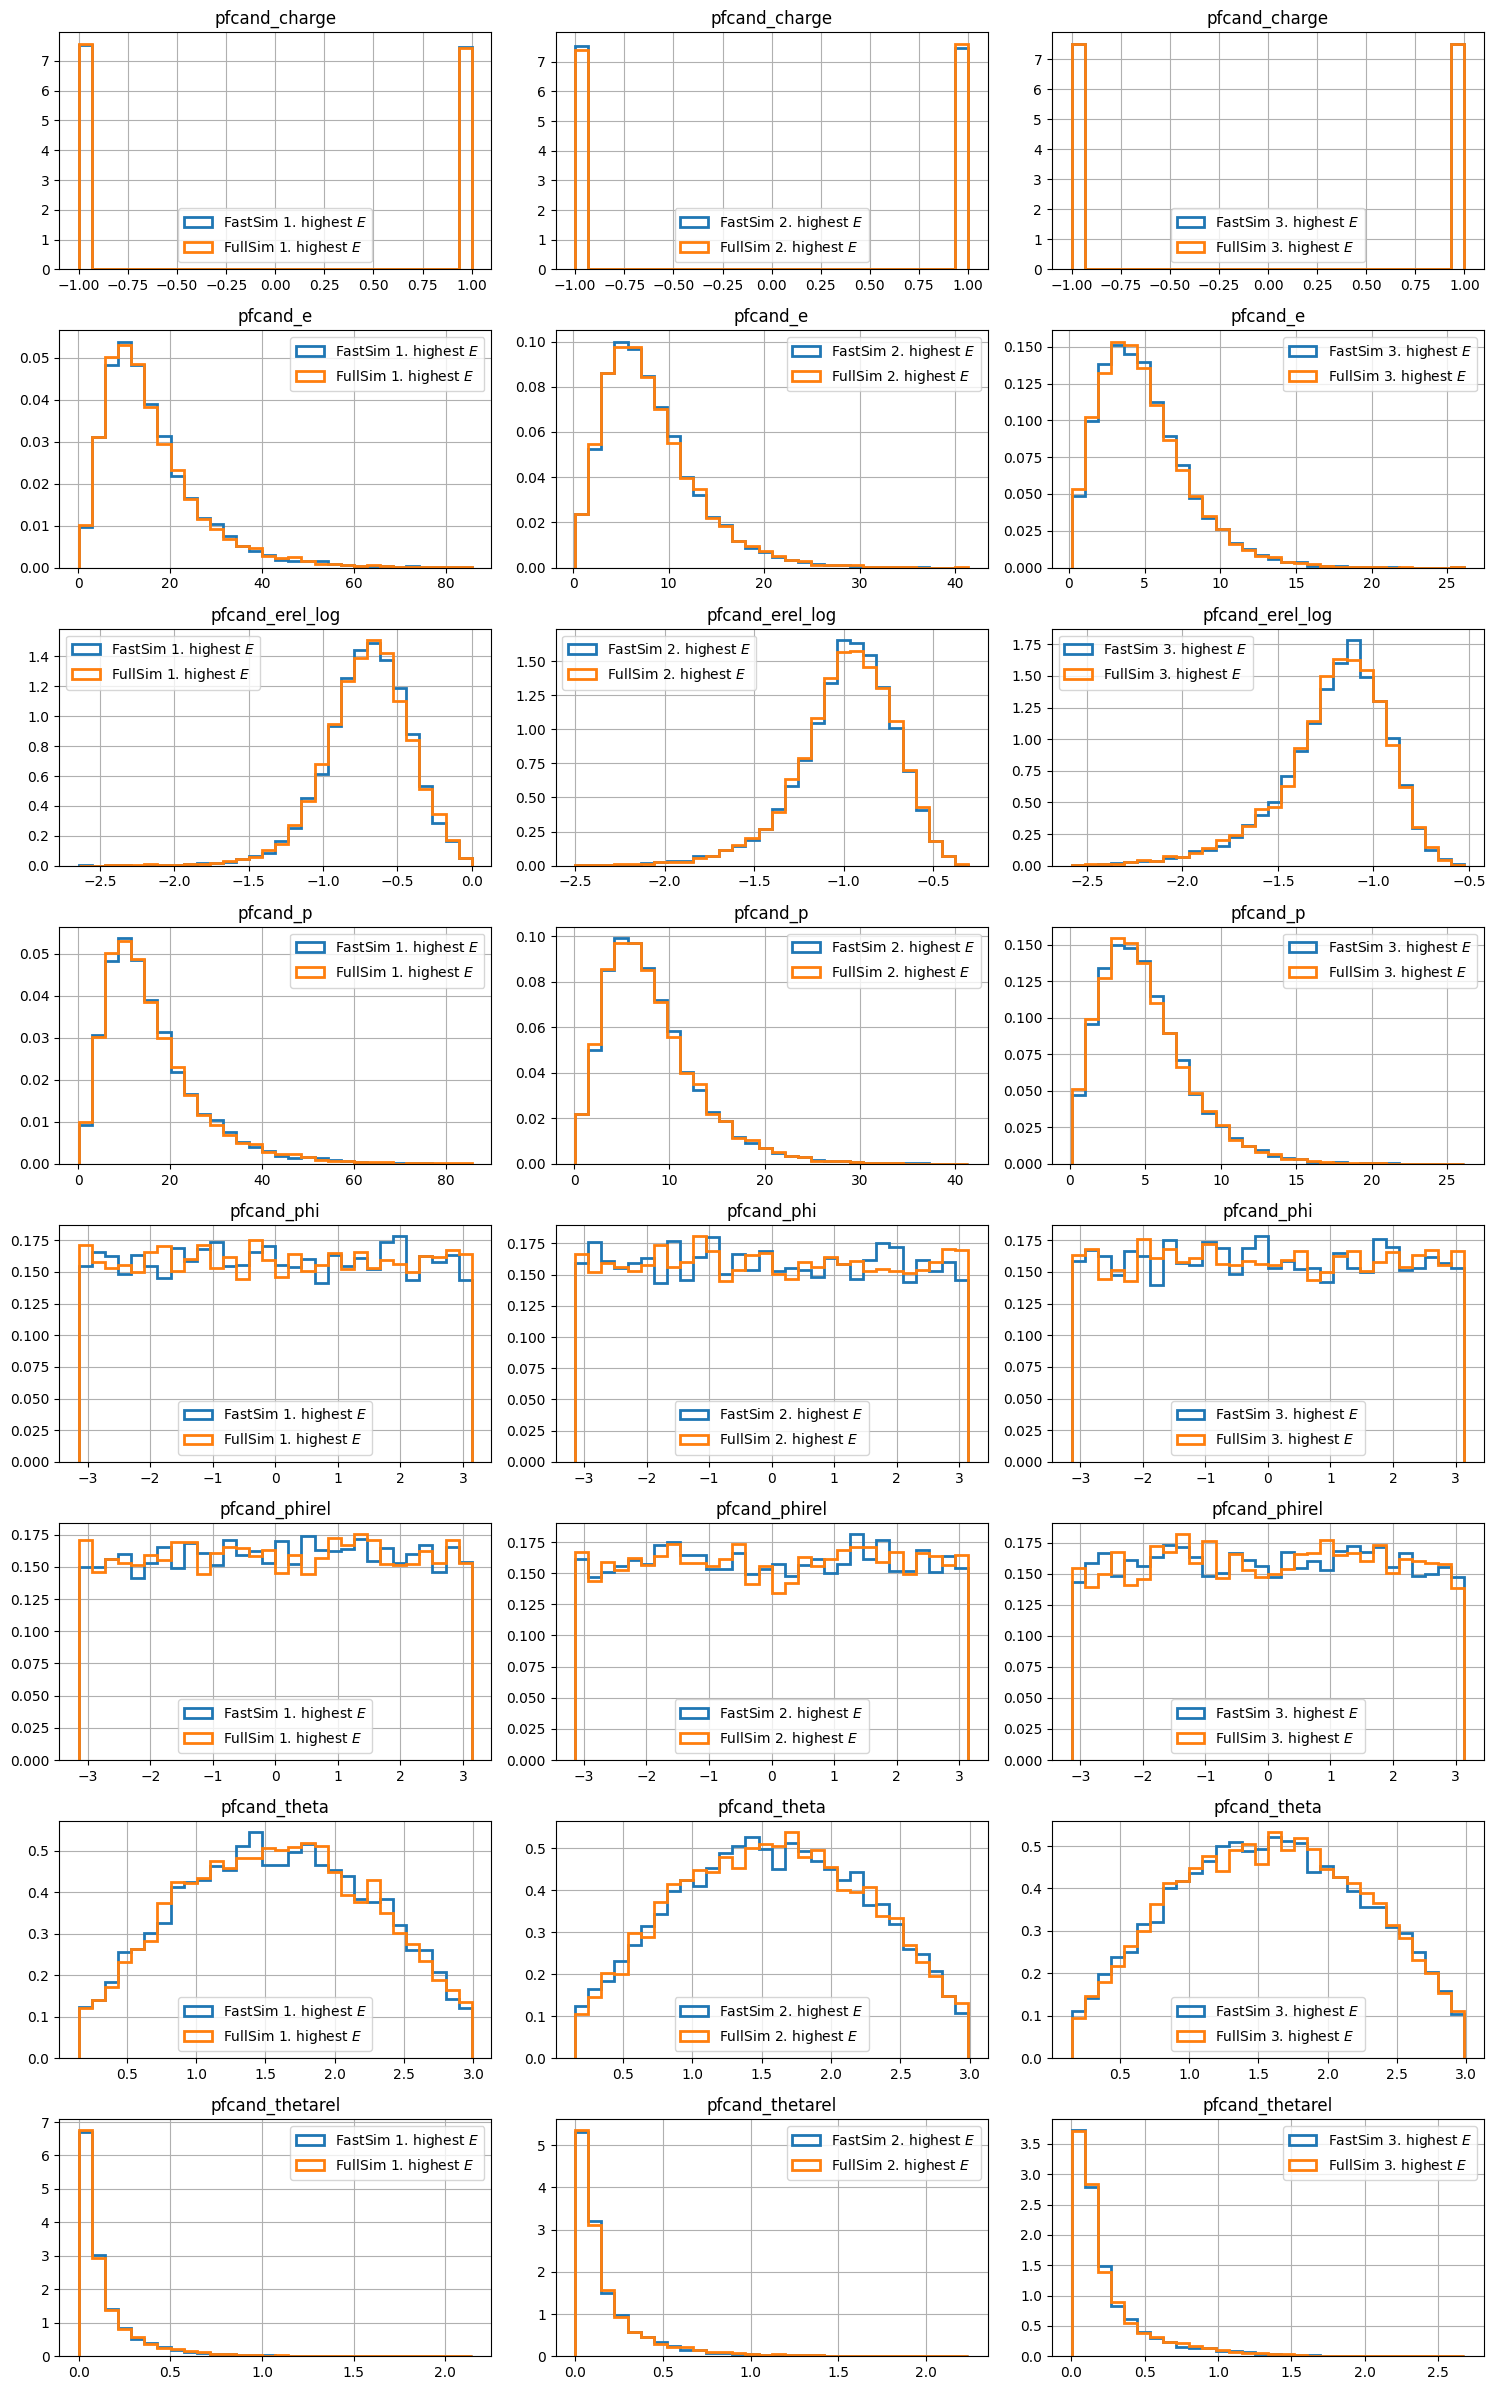

In [21]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

plot_key_highest_e_cpart(keys, bins=30, save=save_status, path='./hist/jetct_cp_properties.pdf')

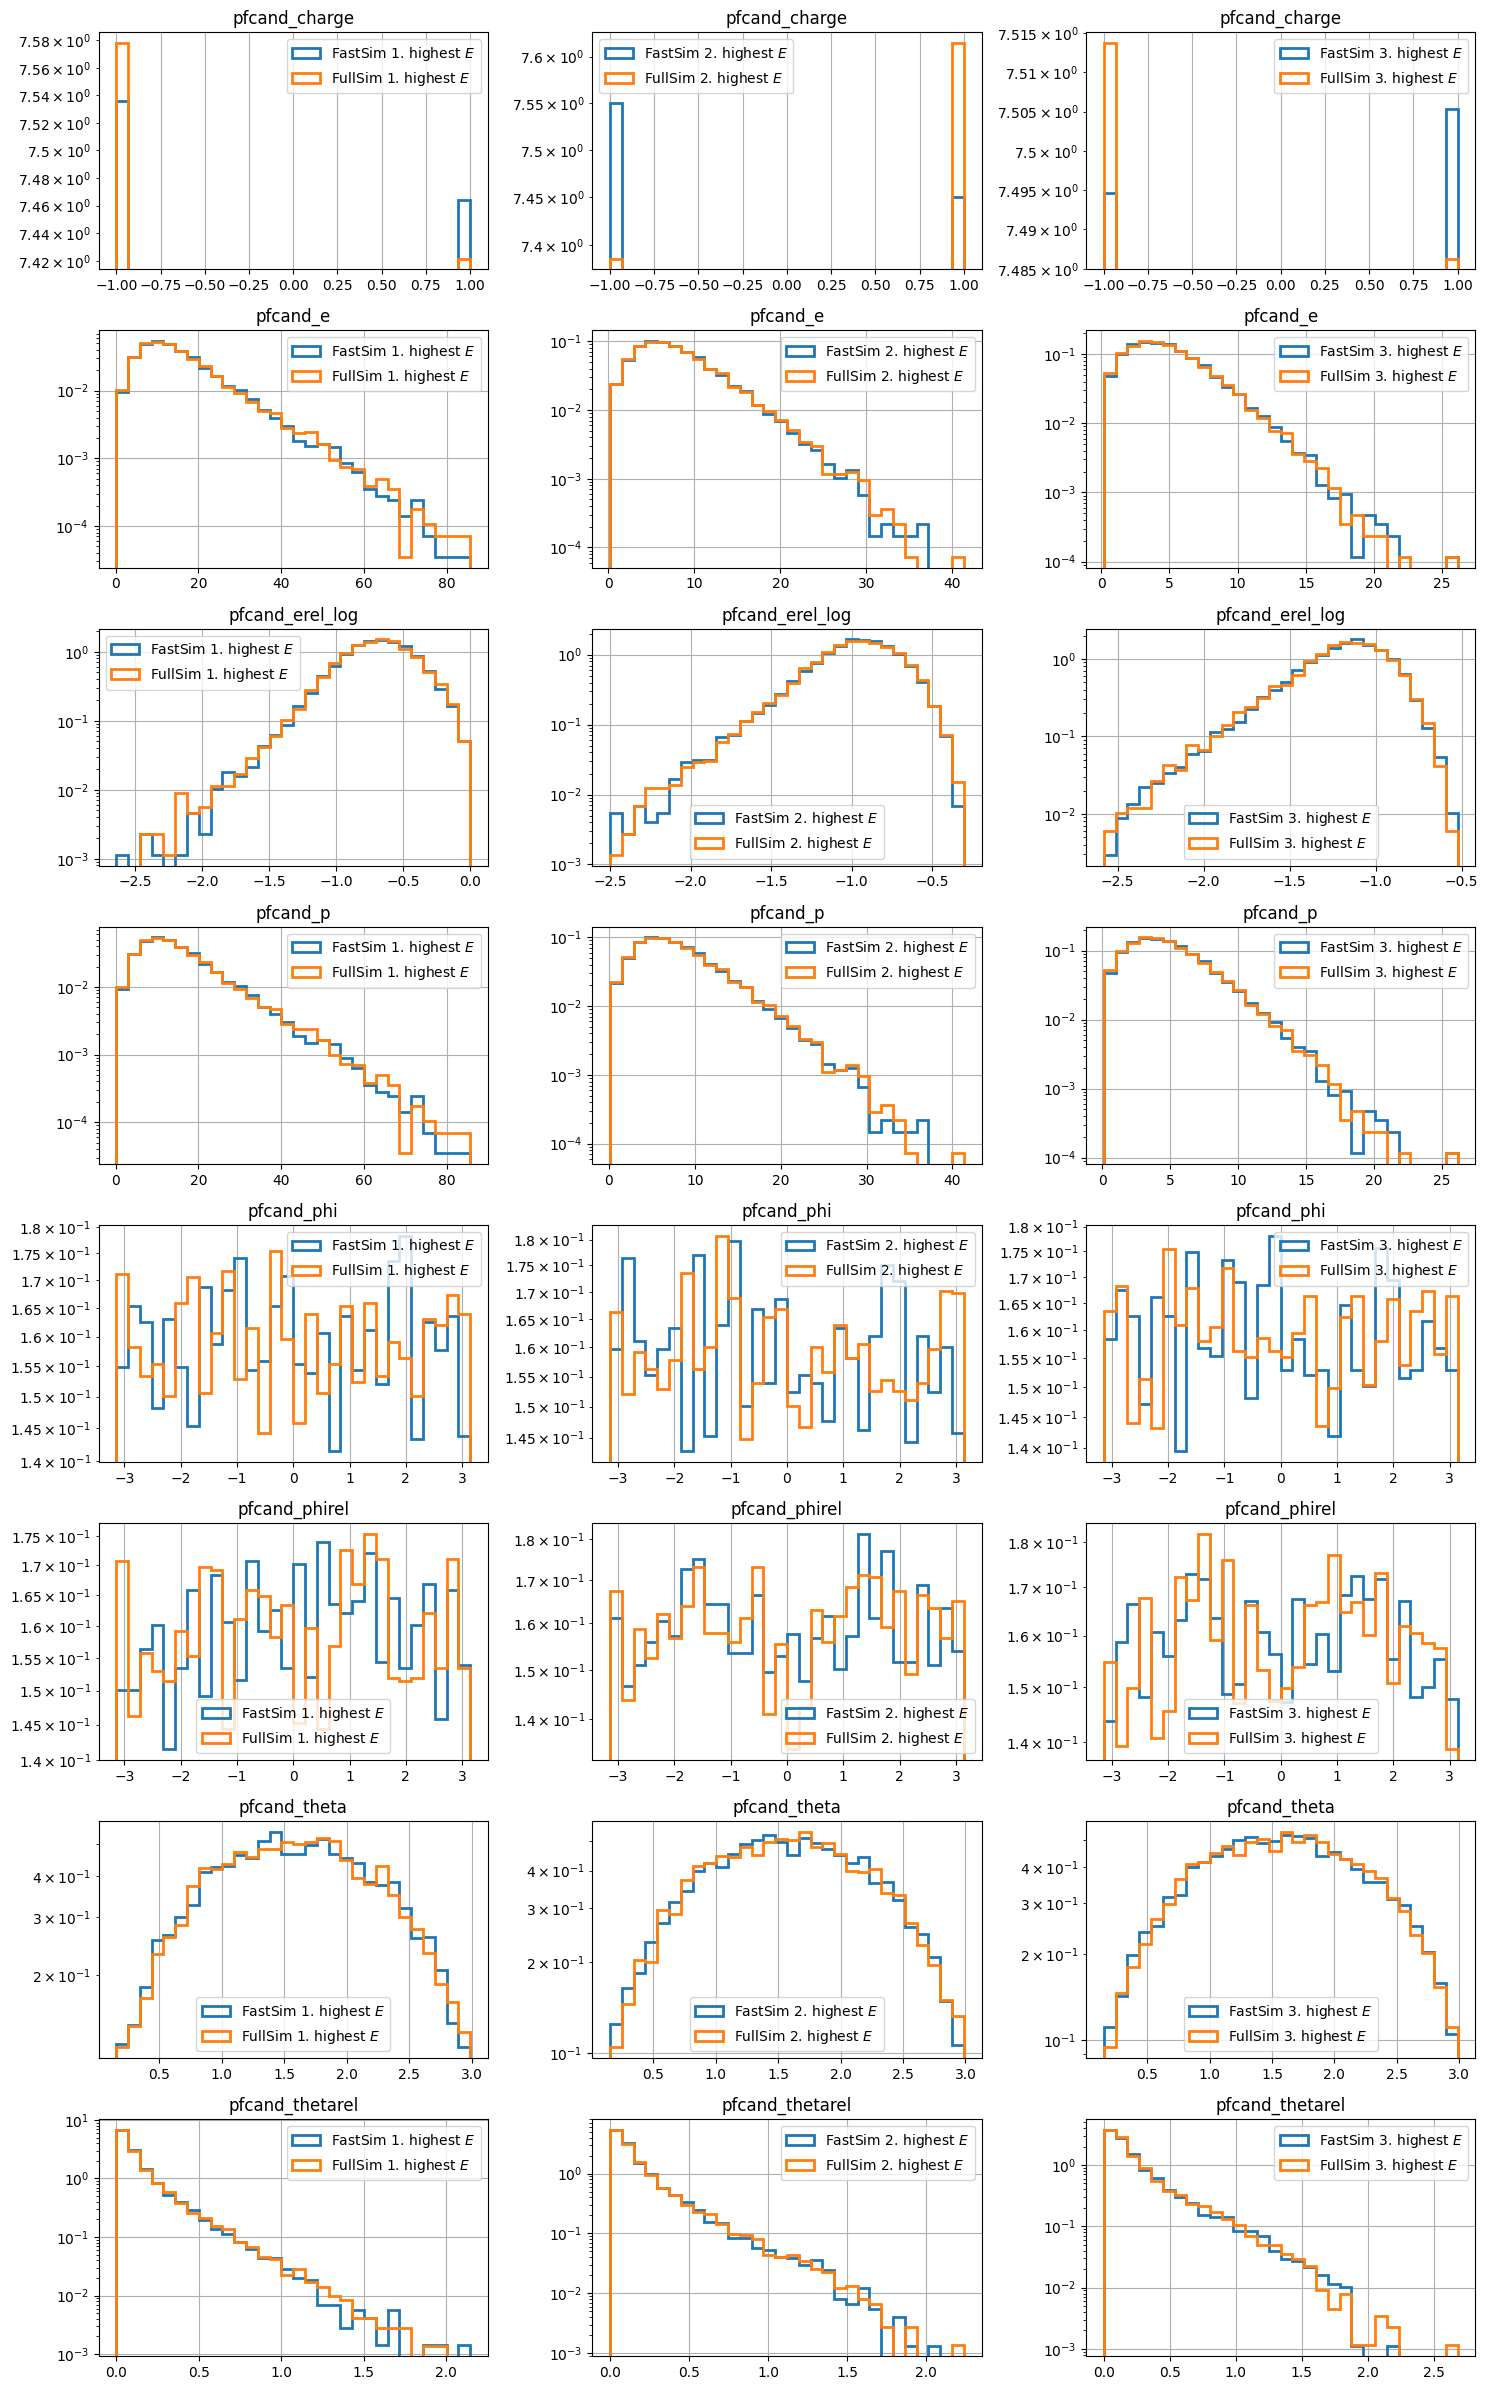

In [22]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

plot_key_highest_e_cpart(keys, bins=30, save=save_status, log=True, path='./hist/jetct_cp_properties_log.pdf')

Looks good!

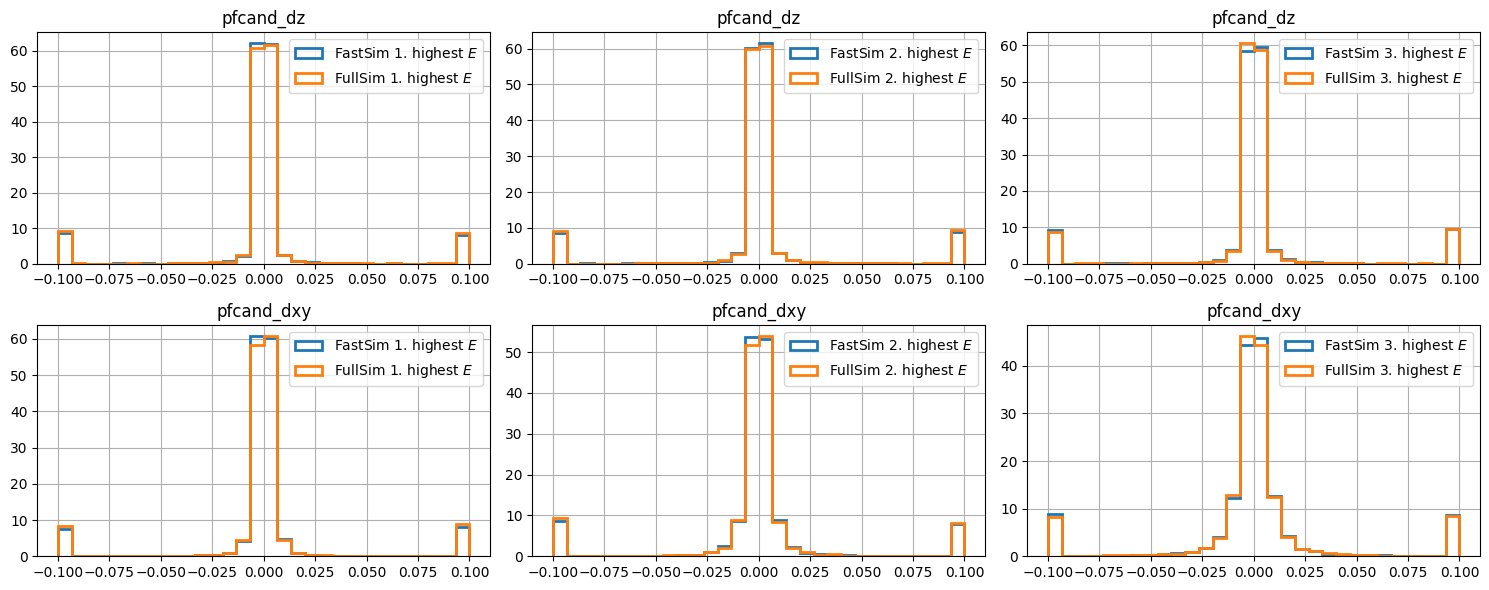

In [23]:
keys = ['pfcand_dz',
        'pfcand_dxy']

ranges = {
    'pfcand_dz': [-0.1, 0.1],
    'pfcand_dxy': [-0.1, 0.1]}

plot_key_highest_e_cpart(keys, r=ranges, bins=30, save=save_status, path='./hist/jetct_cp_ip.pdf')

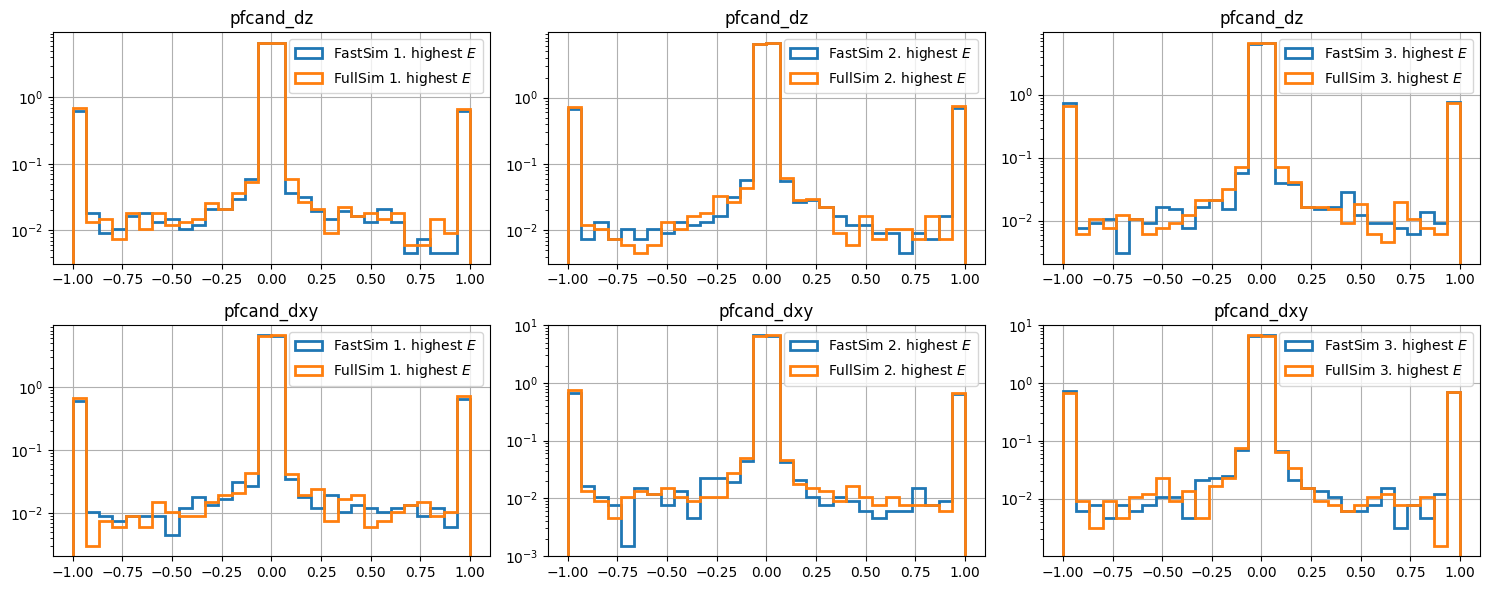

In [24]:
keys = ['pfcand_dz',
        'pfcand_dxy']

ranges = {
    'pfcand_dz': [-1, 1],
    'pfcand_dxy': [-1, 1]}

plot_key_highest_e_cpart(keys, r=ranges, bins=30, log=True, save=save_status, path='./hist/jetct_cp_ip_log.pdf')

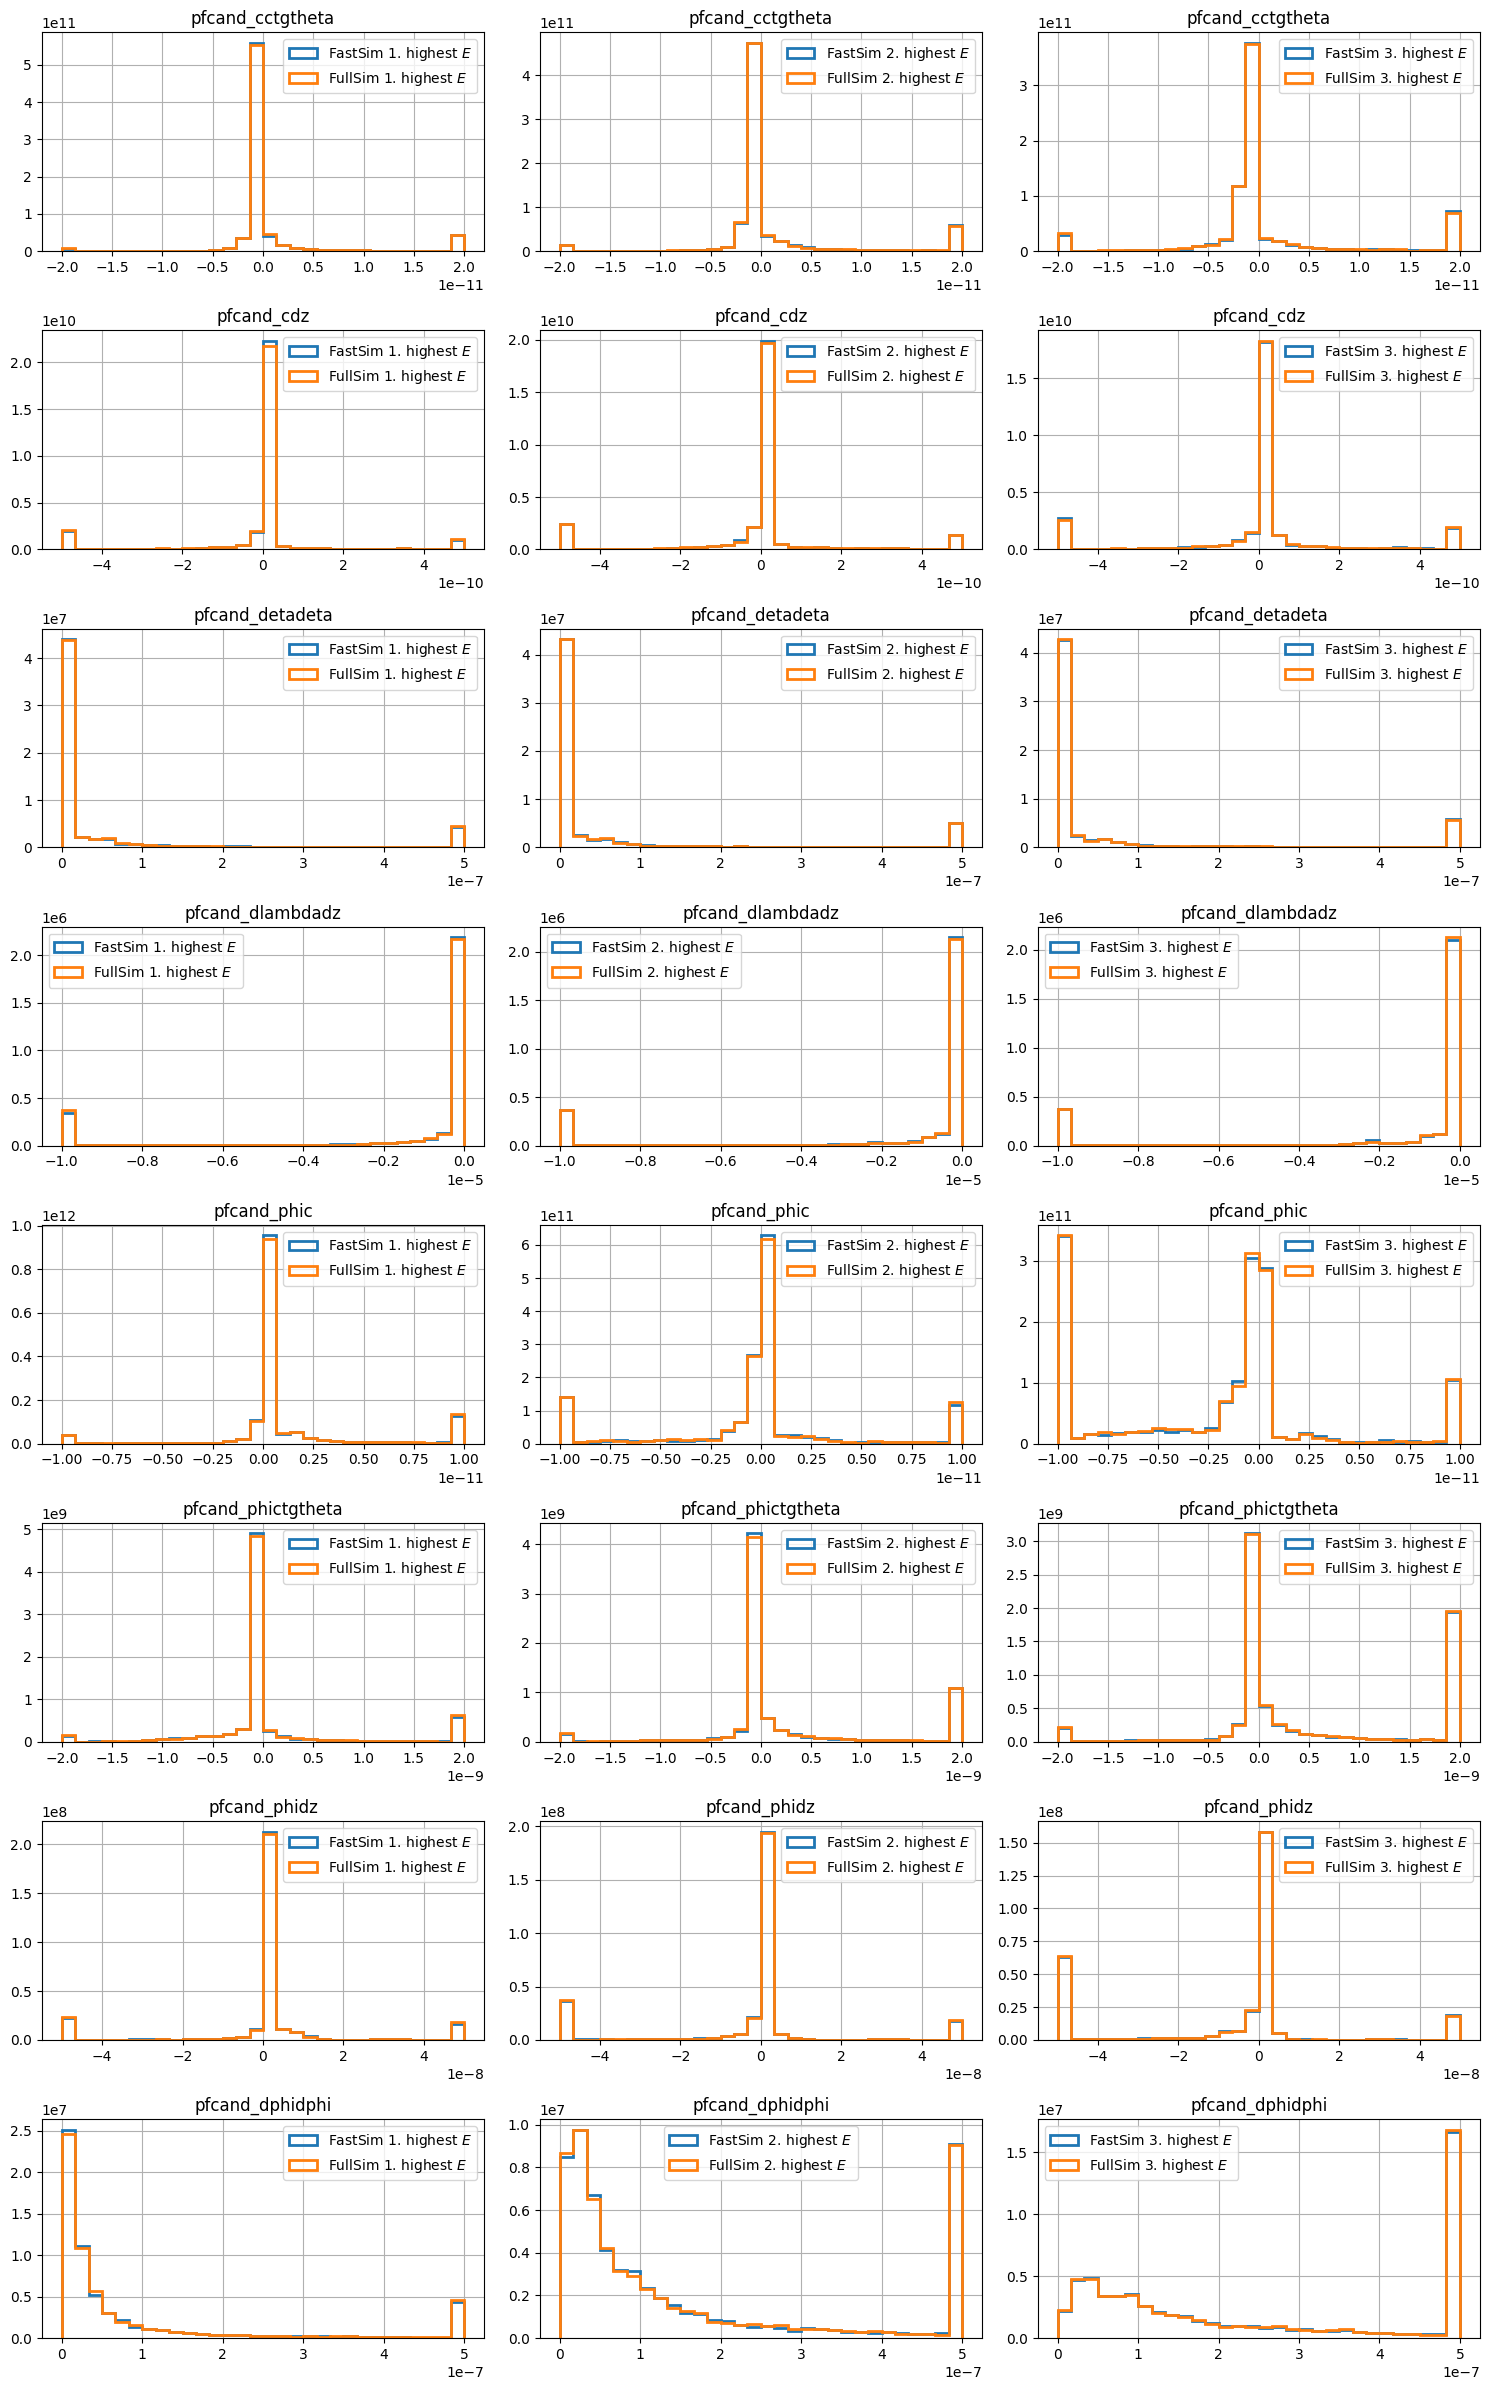

In [25]:
# this plot should be better because we look at charged hadrons only which leave a track!

keys = [
 'pfcand_cctgtheta',
 'pfcand_cdz',
 'pfcand_detadeta',
 'pfcand_dlambdadz',
 'pfcand_phic',
 'pfcand_phictgtheta',
 'pfcand_phidz',
 'pfcand_dphidphi']

ranges = {
    'pfcand_cctgtheta': [-0.2e-10, 0.2e-10],
    'pfcand_cdz': [-0.5e-09, 0.5e-09],
    'pfcand_detadeta': [0, 0.5e-6],
    'pfcand_dlambdadz': [-1e-5, 0],
    'pfcand_phic': [-0.1e-10, 0.1e-10],
    'pfcand_phictgtheta': [-0.2e-08, 0.2e-08], 
    'pfcand_phidz': [-0.05e-6, 0.05e-6],
    'pfcand_dphidphi': [0.0, 0.5e-6]
}

plot_key_highest_e_cpart(keys, r=ranges, bins=30, save=save_status, path='./hist/jetct_cp_cov1.pdf')

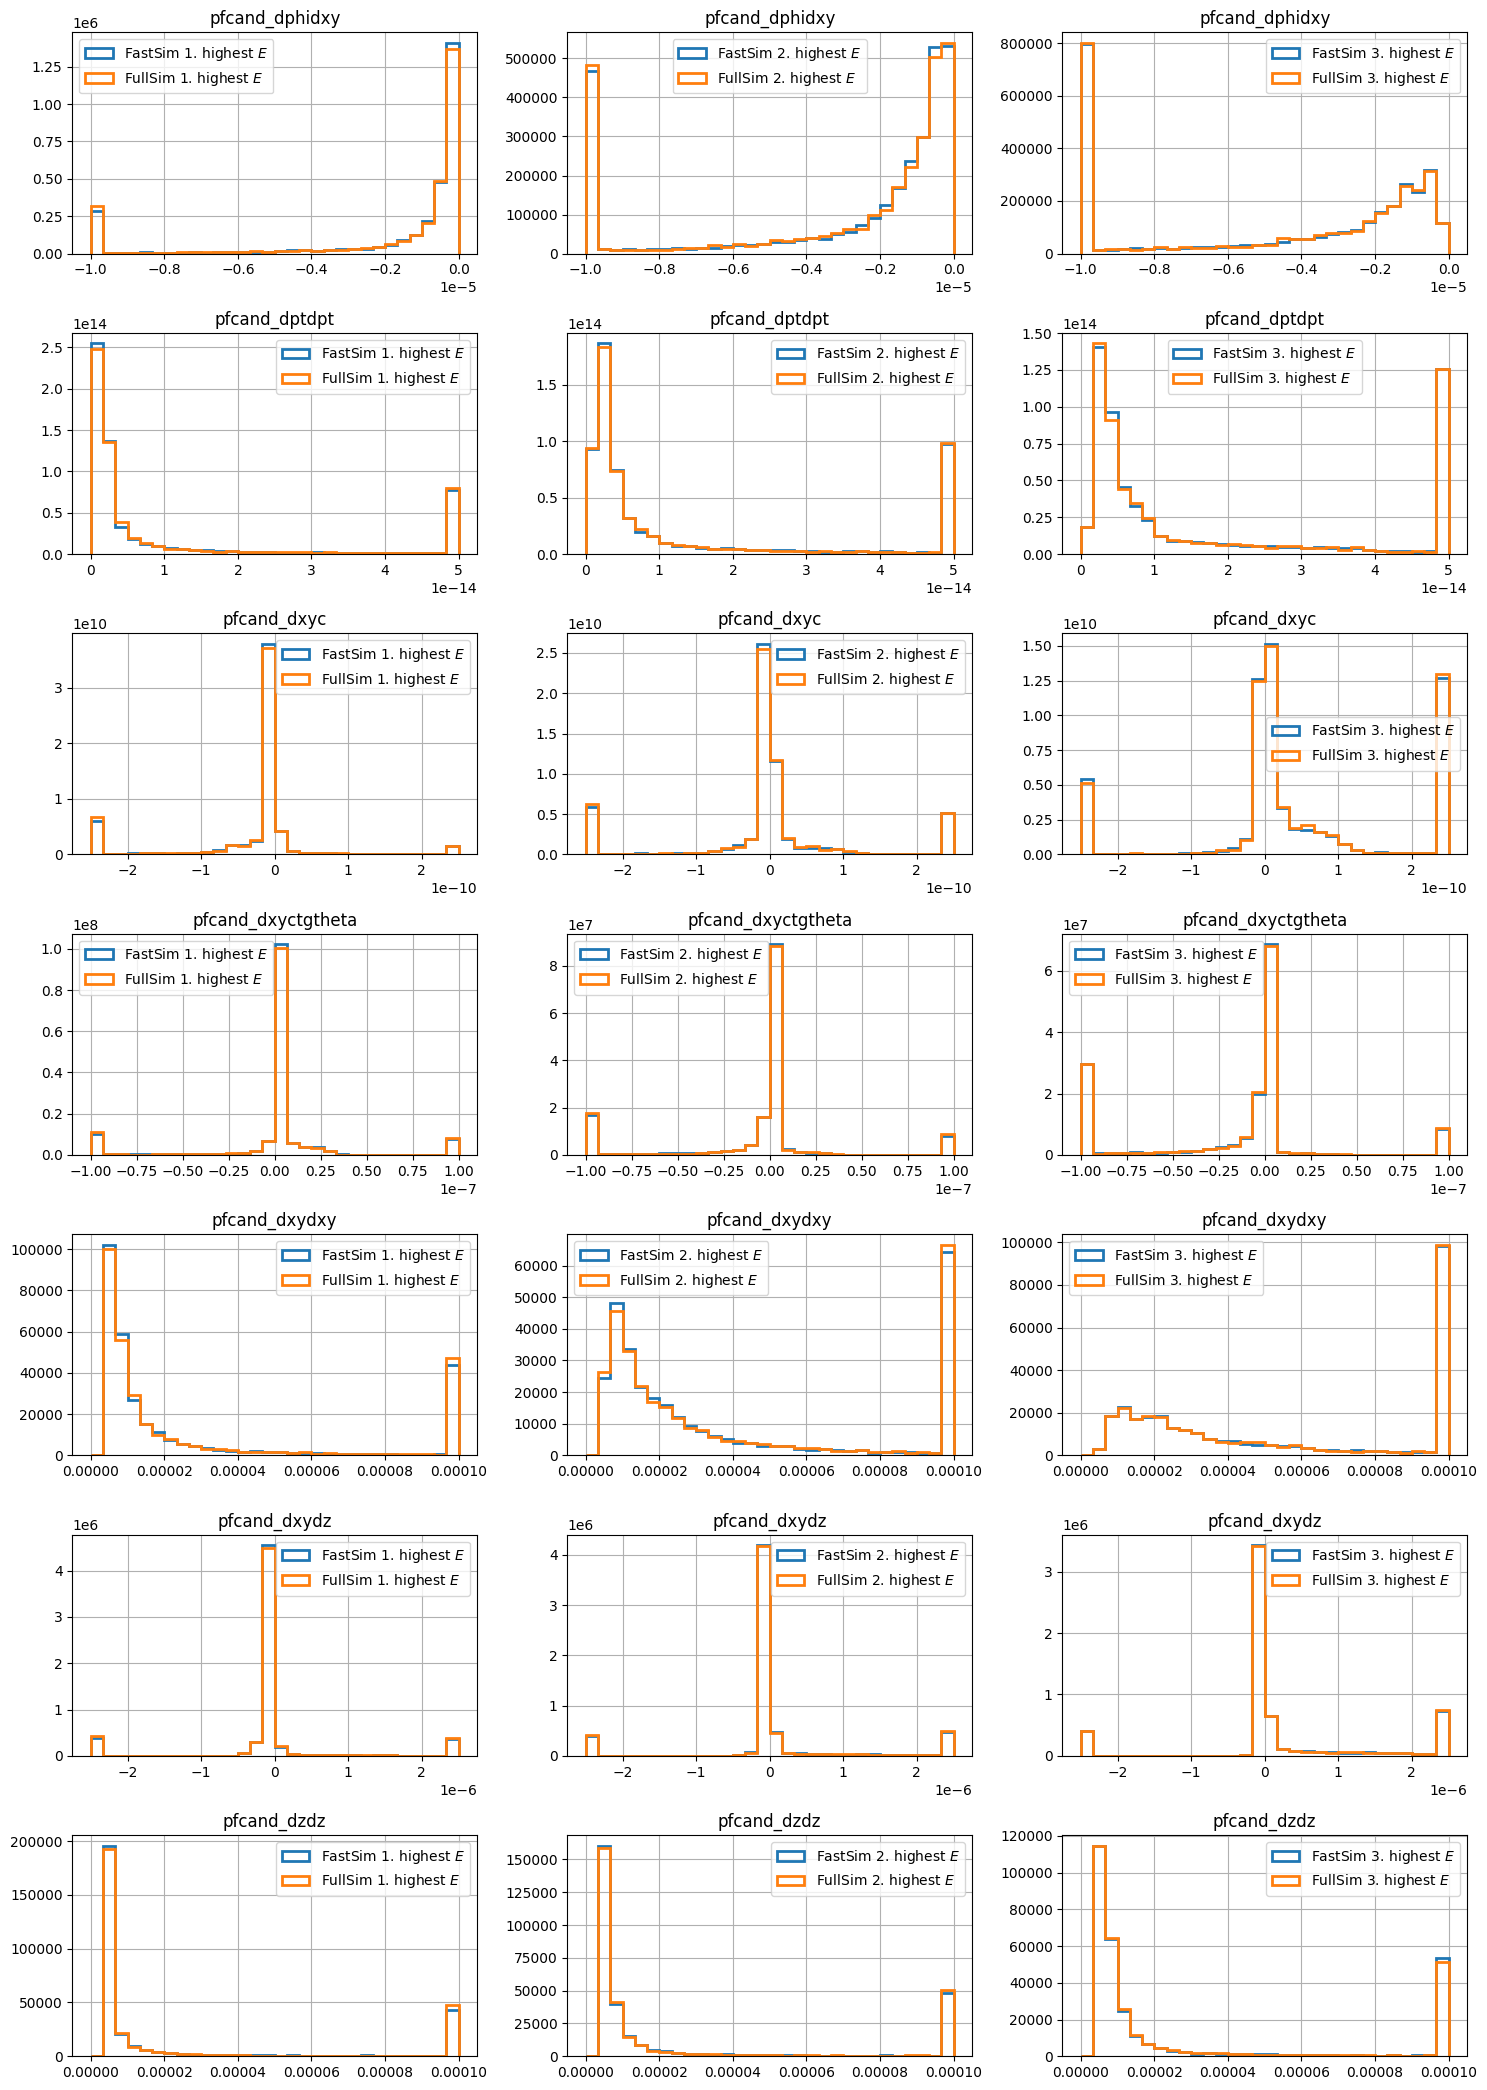

In [26]:
# this plot should be better because we look at charged hadrons only which leave a track!

keys = [
 'pfcand_dphidxy',
 'pfcand_dptdpt',
 'pfcand_dxyc',
 'pfcand_dxyctgtheta',
 'pfcand_dxydxy',
 'pfcand_dxydz',
 'pfcand_dzdz']

ranges = {
    'pfcand_dphidxy': [-1e-5, 0],
    'pfcand_dptdpt': [0, 0.5e-13], 
    'pfcand_dxyc': [-0.25e-9, 0.25e-9],
    'pfcand_dxyctgtheta': [-0.1e-6, 0.1e-6], 
    'pfcand_dxydxy': [0, 1e-4],
    'pfcand_dxydz': [-0.25e-5, 0.25e-5], # here
    'pfcand_dzdz': [0, 1e-4],
}

plot_key_highest_e_cpart(keys, r=ranges, bins=30, save=save_status, path='./hist/jetct_cp_cov2.pdf')

Like above

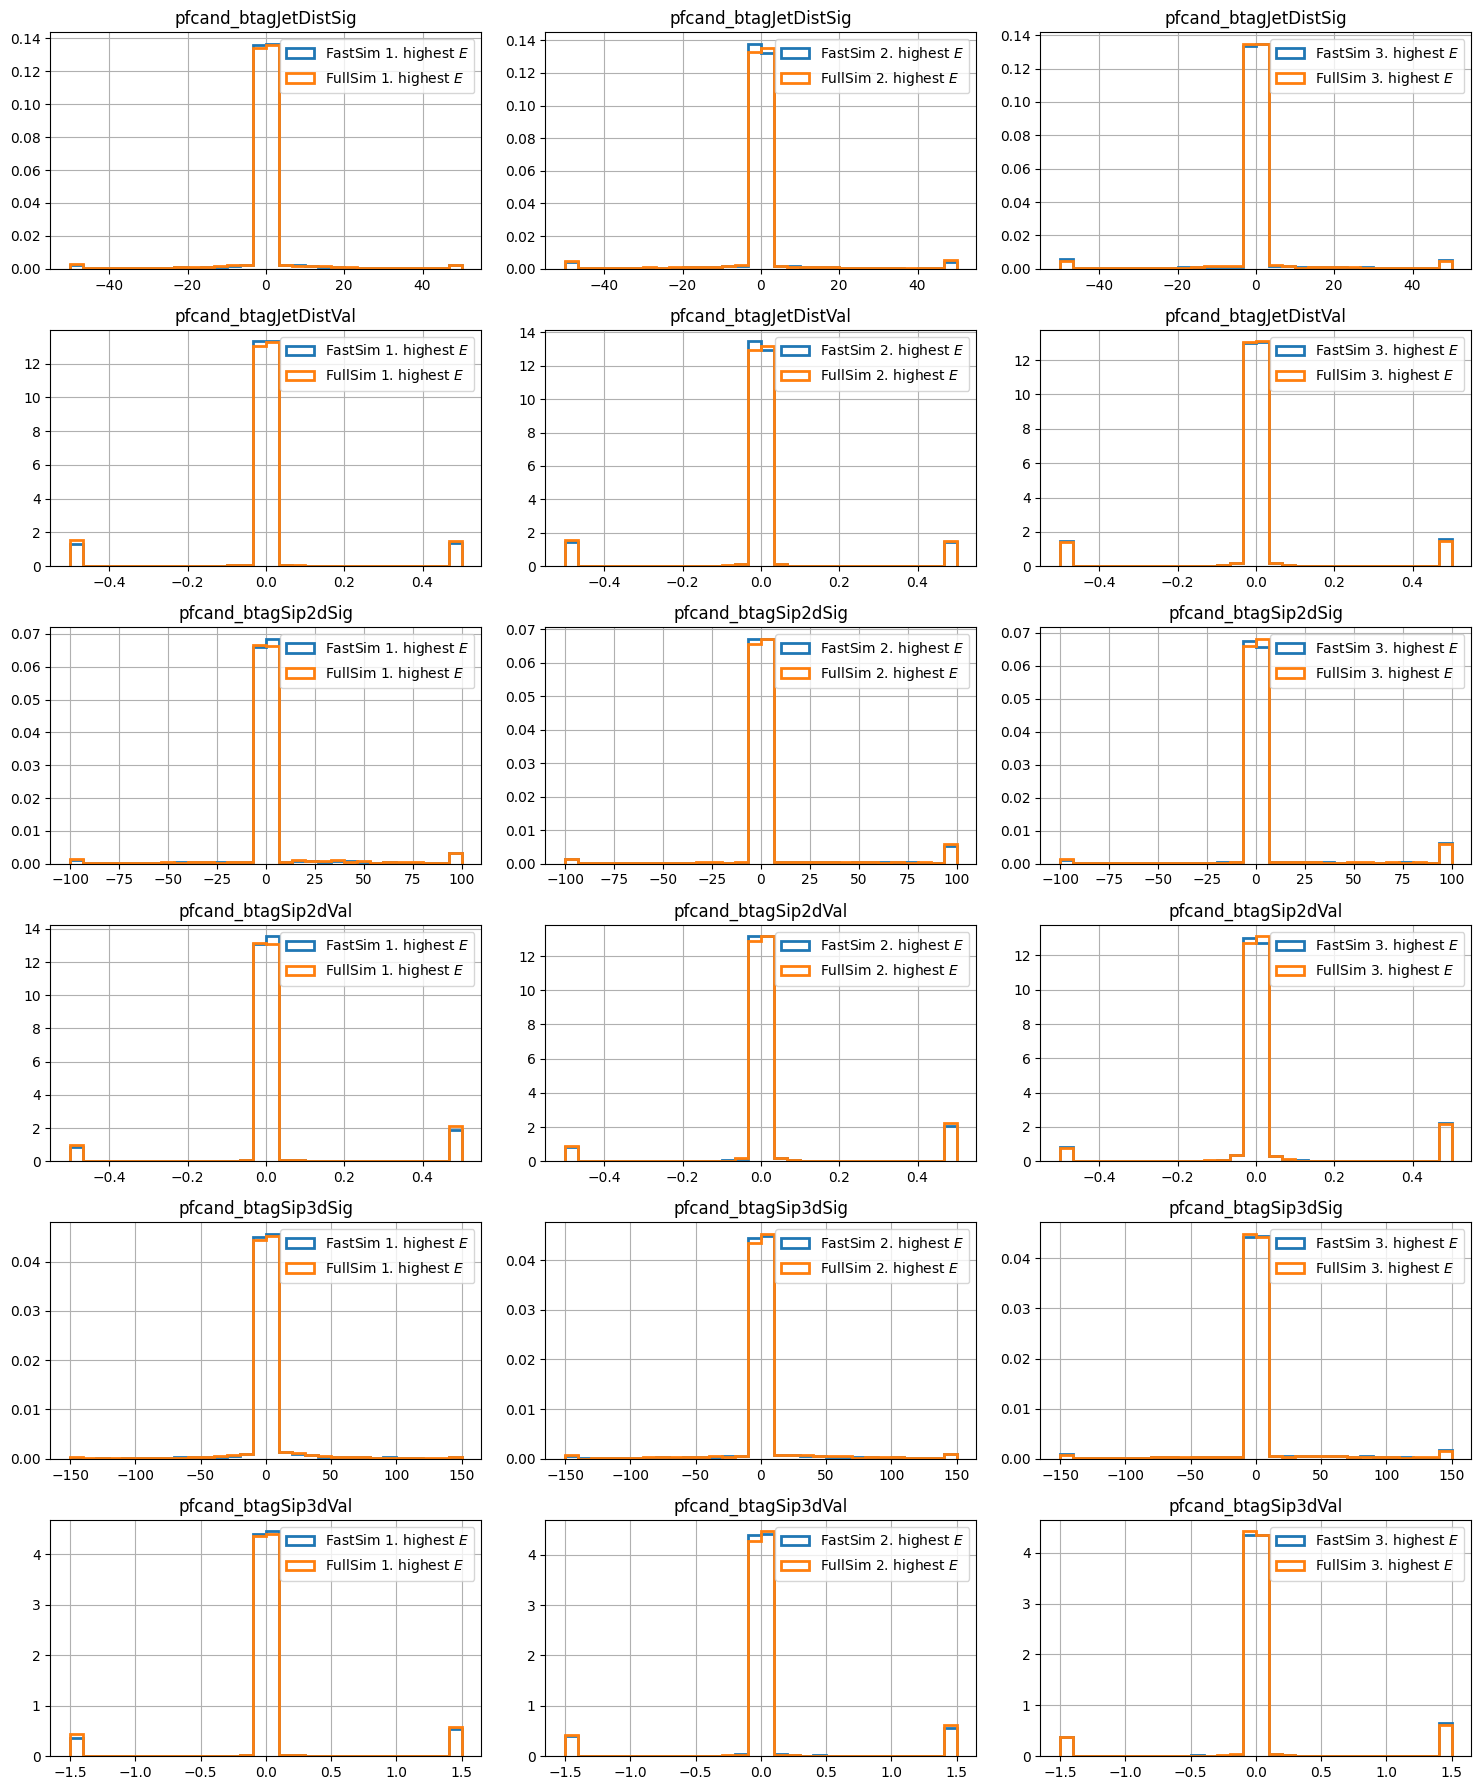

In [27]:


keys = ['pfcand_btagJetDistSig',
 'pfcand_btagJetDistVal',
 'pfcand_btagSip2dSig',
 'pfcand_btagSip2dVal',
 'pfcand_btagSip3dSig',
 'pfcand_btagSip3dVal']

ranges = {
    'pfcand_btagJetDistSig': [-50, 50],
    'pfcand_btagJetDistVal': [-0.5, 0.5],
    'pfcand_btagSip2dSig': [-100, 100],
    'pfcand_btagSip2dVal': [-0.5, 0.5],
    'pfcand_btagSip3dSig': [-150, 150],
    'pfcand_btagSip3dVal': [-1.5, 1.5]
}

plot_key_highest_e_cpart(keys, r=ranges, bins=30, save=save_status, path='./hist/jetct_cp_dist.pdf')

Let's see if we can spot the dip like in Micheles paper!

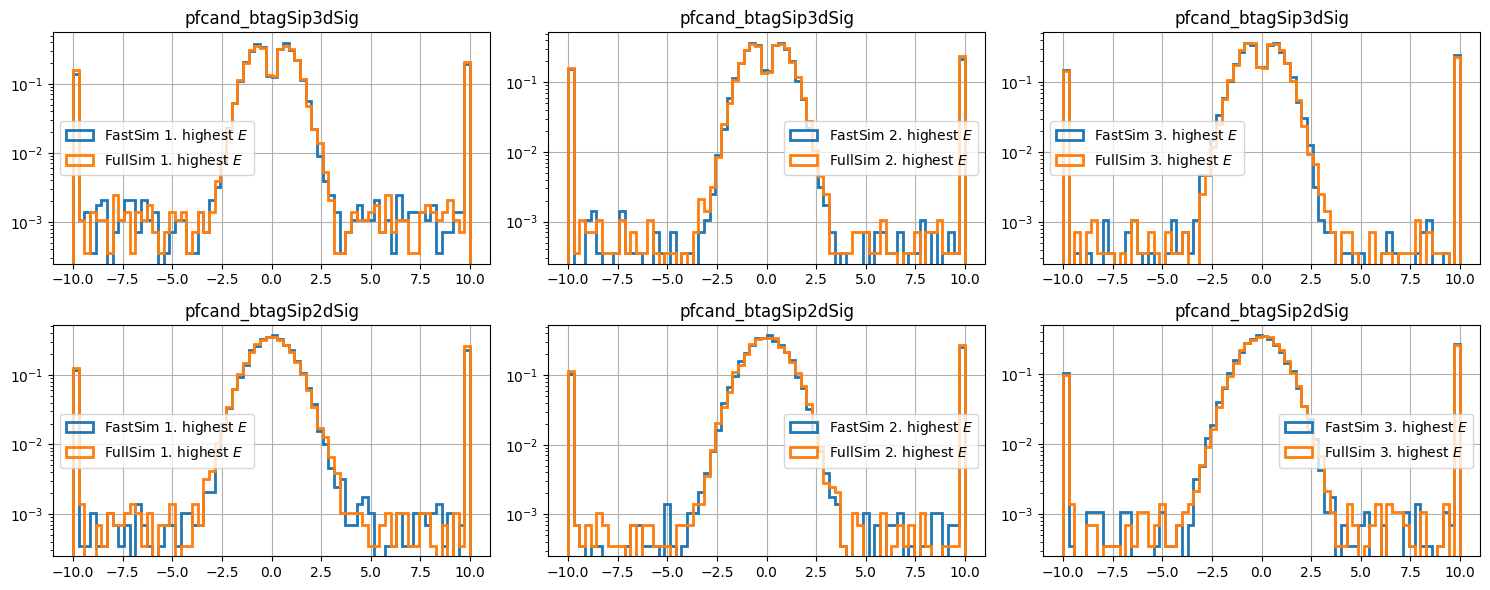

In [28]:
# these plots make even more sense than the one above because we look at charged hadrons only which leave a track!

keys = [
 'pfcand_btagSip3dSig',
 'pfcand_btagSip2dSig',
]

ranges = {
    'pfcand_btagSip3dSig': [-10, 10],
    'pfcand_btagSip2dSig': [-10, 10],
}

plot_key_highest_e_cpart(keys, r=ranges, bins=70, log=True, save=save_status, path='./hist/jetct_cp_sip_dip.pdf')

## Alright: Now neutral particles!

In [29]:
def plot_key_highest_e_npart(keys, k=3, r=None, bins=20, log=False, save=False, path=None):
    fig, axs = plt.subplots(len(keys), k, figsize=(15, 3 * len(keys))) 

    # loop over keys: 
    for idx, key in enumerate(keys):
        a_list = get_chad_elements(df_fa[key], index_neutral_3E_fa)
        b_list = get_chad_elements(df_fu[key], index_neutral_3E_fu)

        ri = r[key] if r != None else None
        for i in range(k):
            ax = axs[idx, i]
            
            a = a_list[i]
            b = b_list[i]

            if ri == None:
                combined_min = min(a.min(), b.min())
                combined_max = max(a.max(), b.max())
                combined_range = (combined_min, combined_max)
            else:
                combined_range = ri
                # make overflow bins
                a = np.clip(a, *combined_range)
                b = np.clip(b, *combined_range)
            
            ax.set_title(key)
            ax.hist(a, bins=bins, histtype='step', linewidth=2.0, range=combined_range, label=f'FastSim {i+1}'+r'. highest $E$', density=True)
            ax.hist(b, bins=bins, histtype='step', linewidth=2.0, range=combined_range, label=f'FullSim {i+1}'+r'. highest $E$', density=True)
            if log:
                ax.set_yscale('log')
            ax.legend()
            ax.grid()
    plt.tight_layout()
    if save:
        if path==None:
            path = './hist/histogram.pdf'
        plt.savefig(path)
    plt.show()

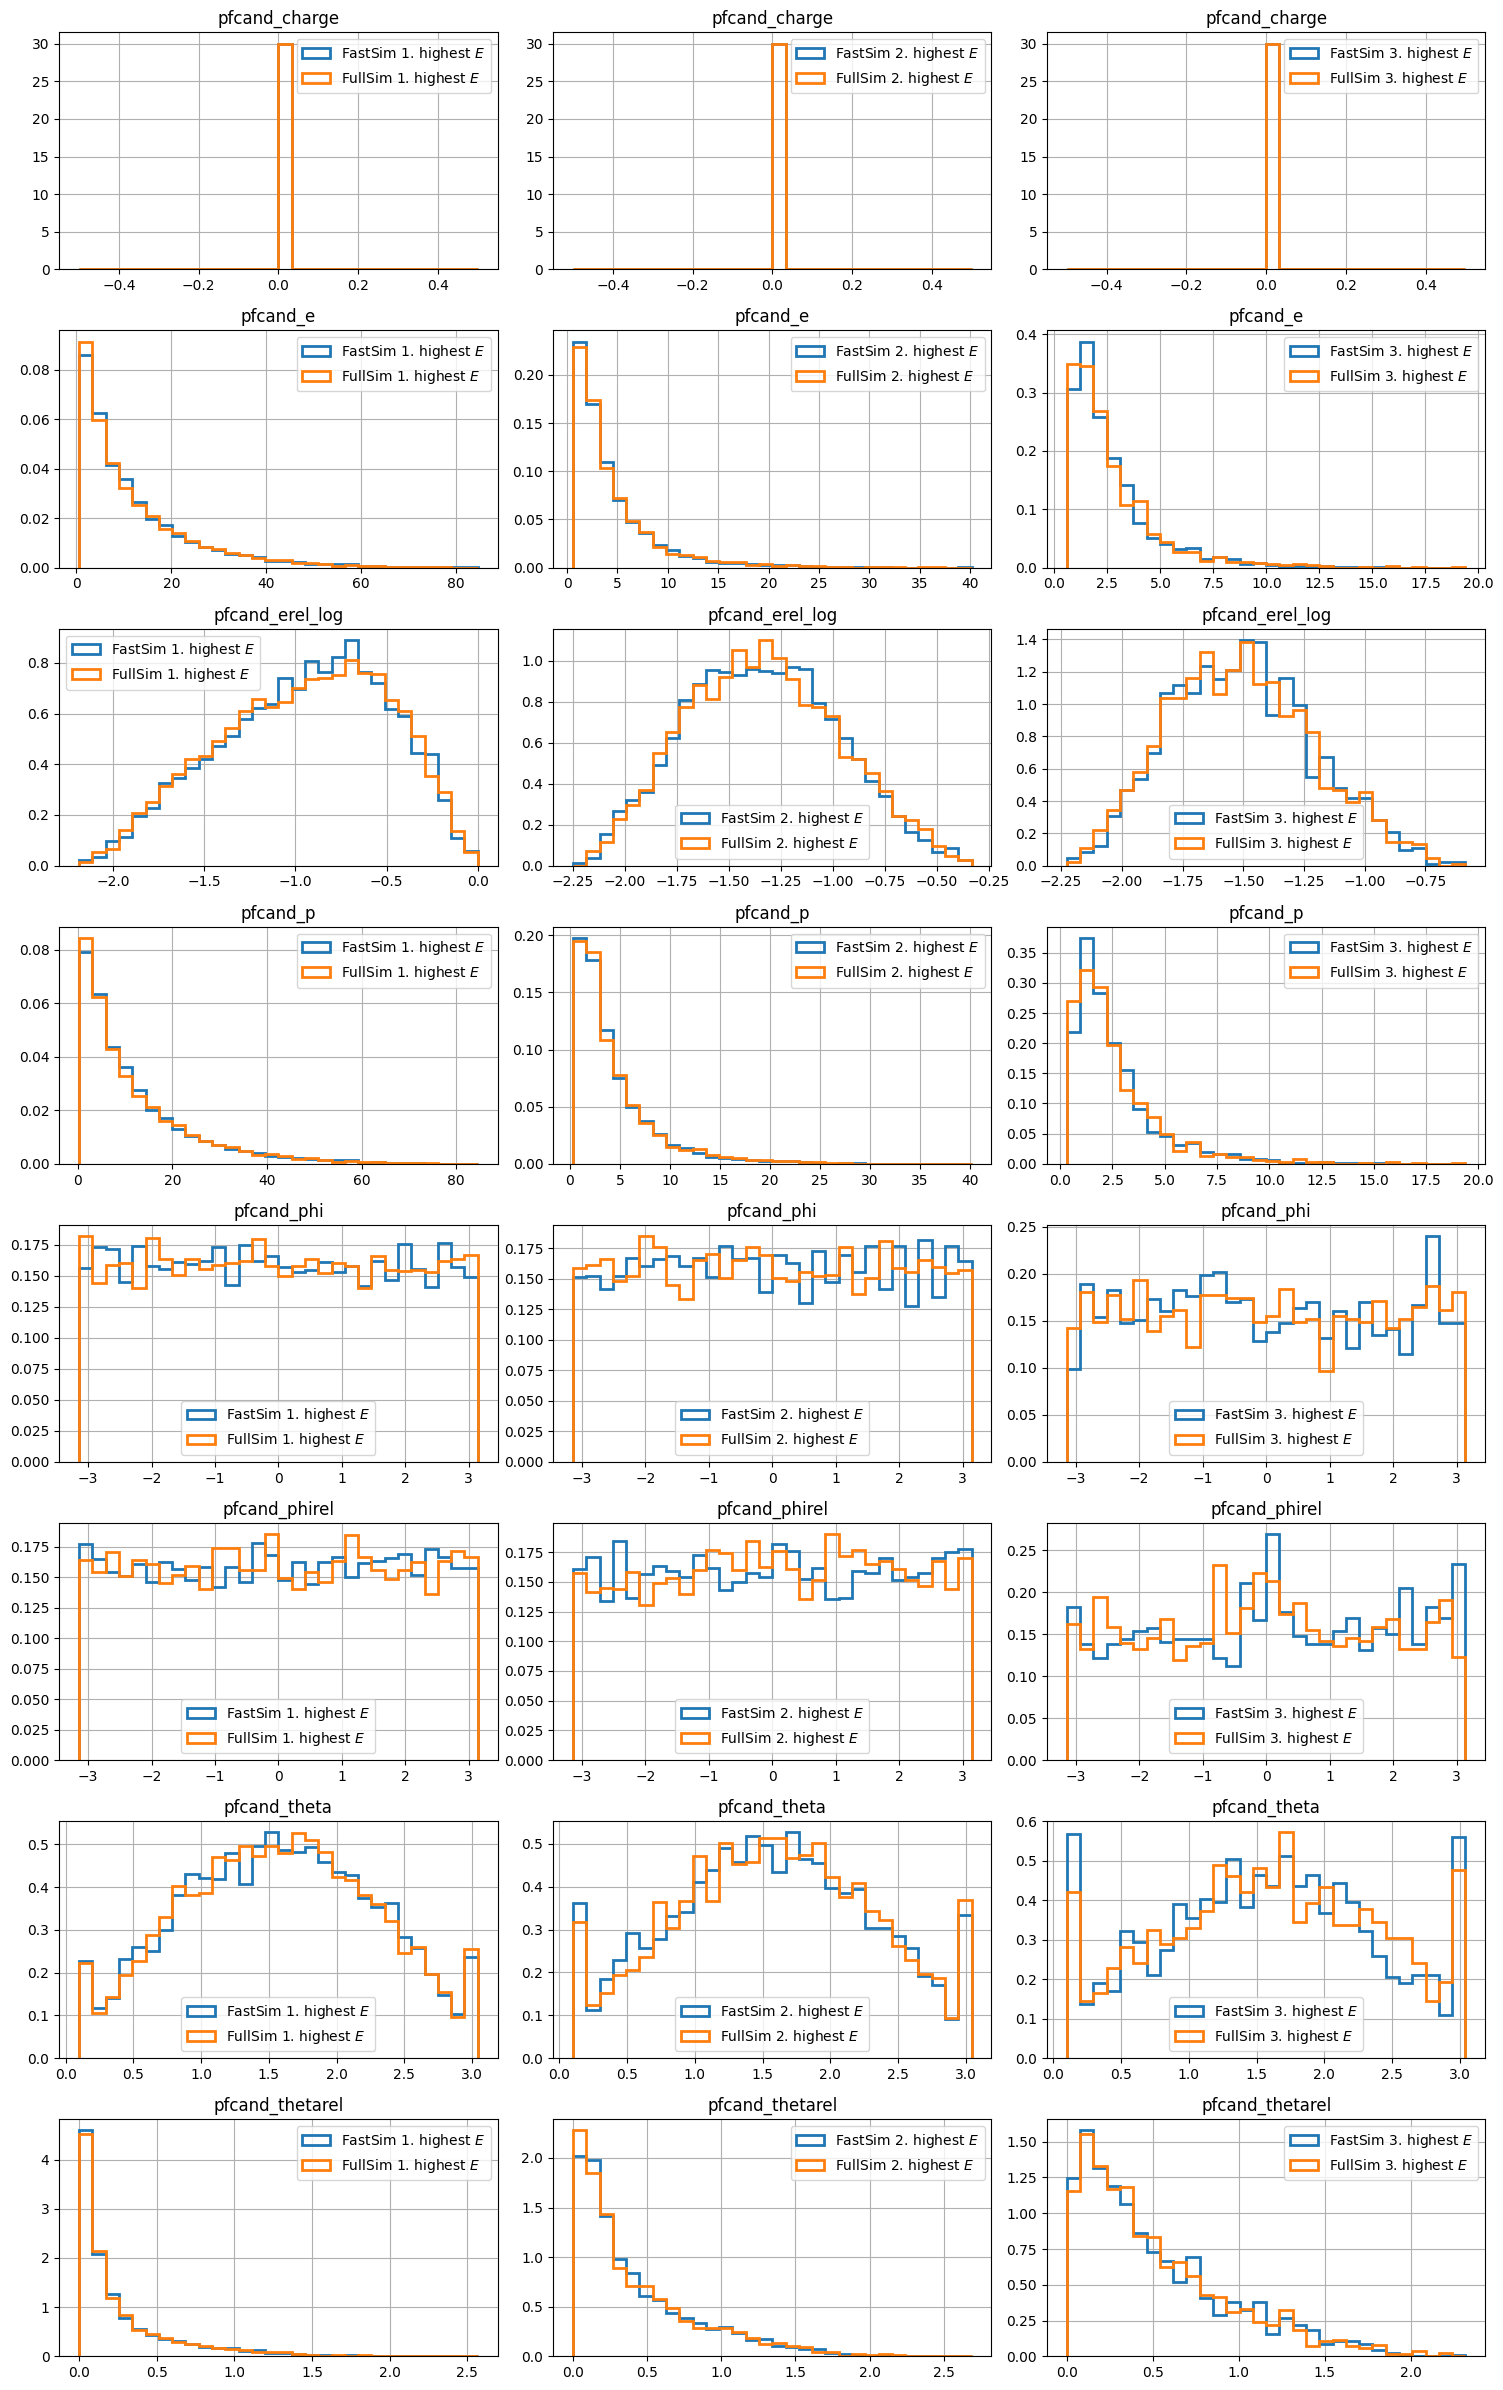

In [30]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

plot_key_highest_e_npart(keys, bins=30, save=save_status, path='./hist/jetct_np_properties.pdf')

We see: less neutrons with small momenta & energy. Distributions look ok'isch?

# For completion: Photons

In [31]:
def plot_key_highest_e_photon(keys, k=3, r=None, bins=20, log=False, save=False, path=None):
    fig, axs = plt.subplots(len(keys), k, figsize=(15, 3 * len(keys))) 

    # loop over keys: 
    for idx, key in enumerate(keys):
        a_list = get_chad_elements(df_fa[key], index_photon_3E_fa)
        b_list = get_chad_elements(df_fu[key], index_photon_3E_fu)

        ri = r[key] if r != None else None
        for i in range(k):
            ax = axs[idx, i]
            
            a = a_list[i]
            b = b_list[i]

            if ri == None:
                combined_min = min(a.min(), b.min())
                combined_max = max(a.max(), b.max())
                combined_range = (combined_min, combined_max)
            else:
                combined_range = ri
                # make overflow bins
                a = np.clip(a, *combined_range)
                b = np.clip(b, *combined_range)
            
            ax.set_title(key)
            ax.hist(a, bins=bins, histtype='step', linewidth=2.0, range=combined_range, label=f'FastSim {i+1}'+r'. highest $E$', density=True)
            ax.hist(b, bins=bins, histtype='step', linewidth=2.0, range=combined_range, label=f'FullSim {i+1}'+r'. highest $E$', density=True)
            if log:
                ax.set_yscale('log')
            ax.legend()
            ax.grid()
    plt.tight_layout()
    if save:
        if path==None:
            path = './hist/histogram.pdf'
        plt.savefig(path)
    plt.show()

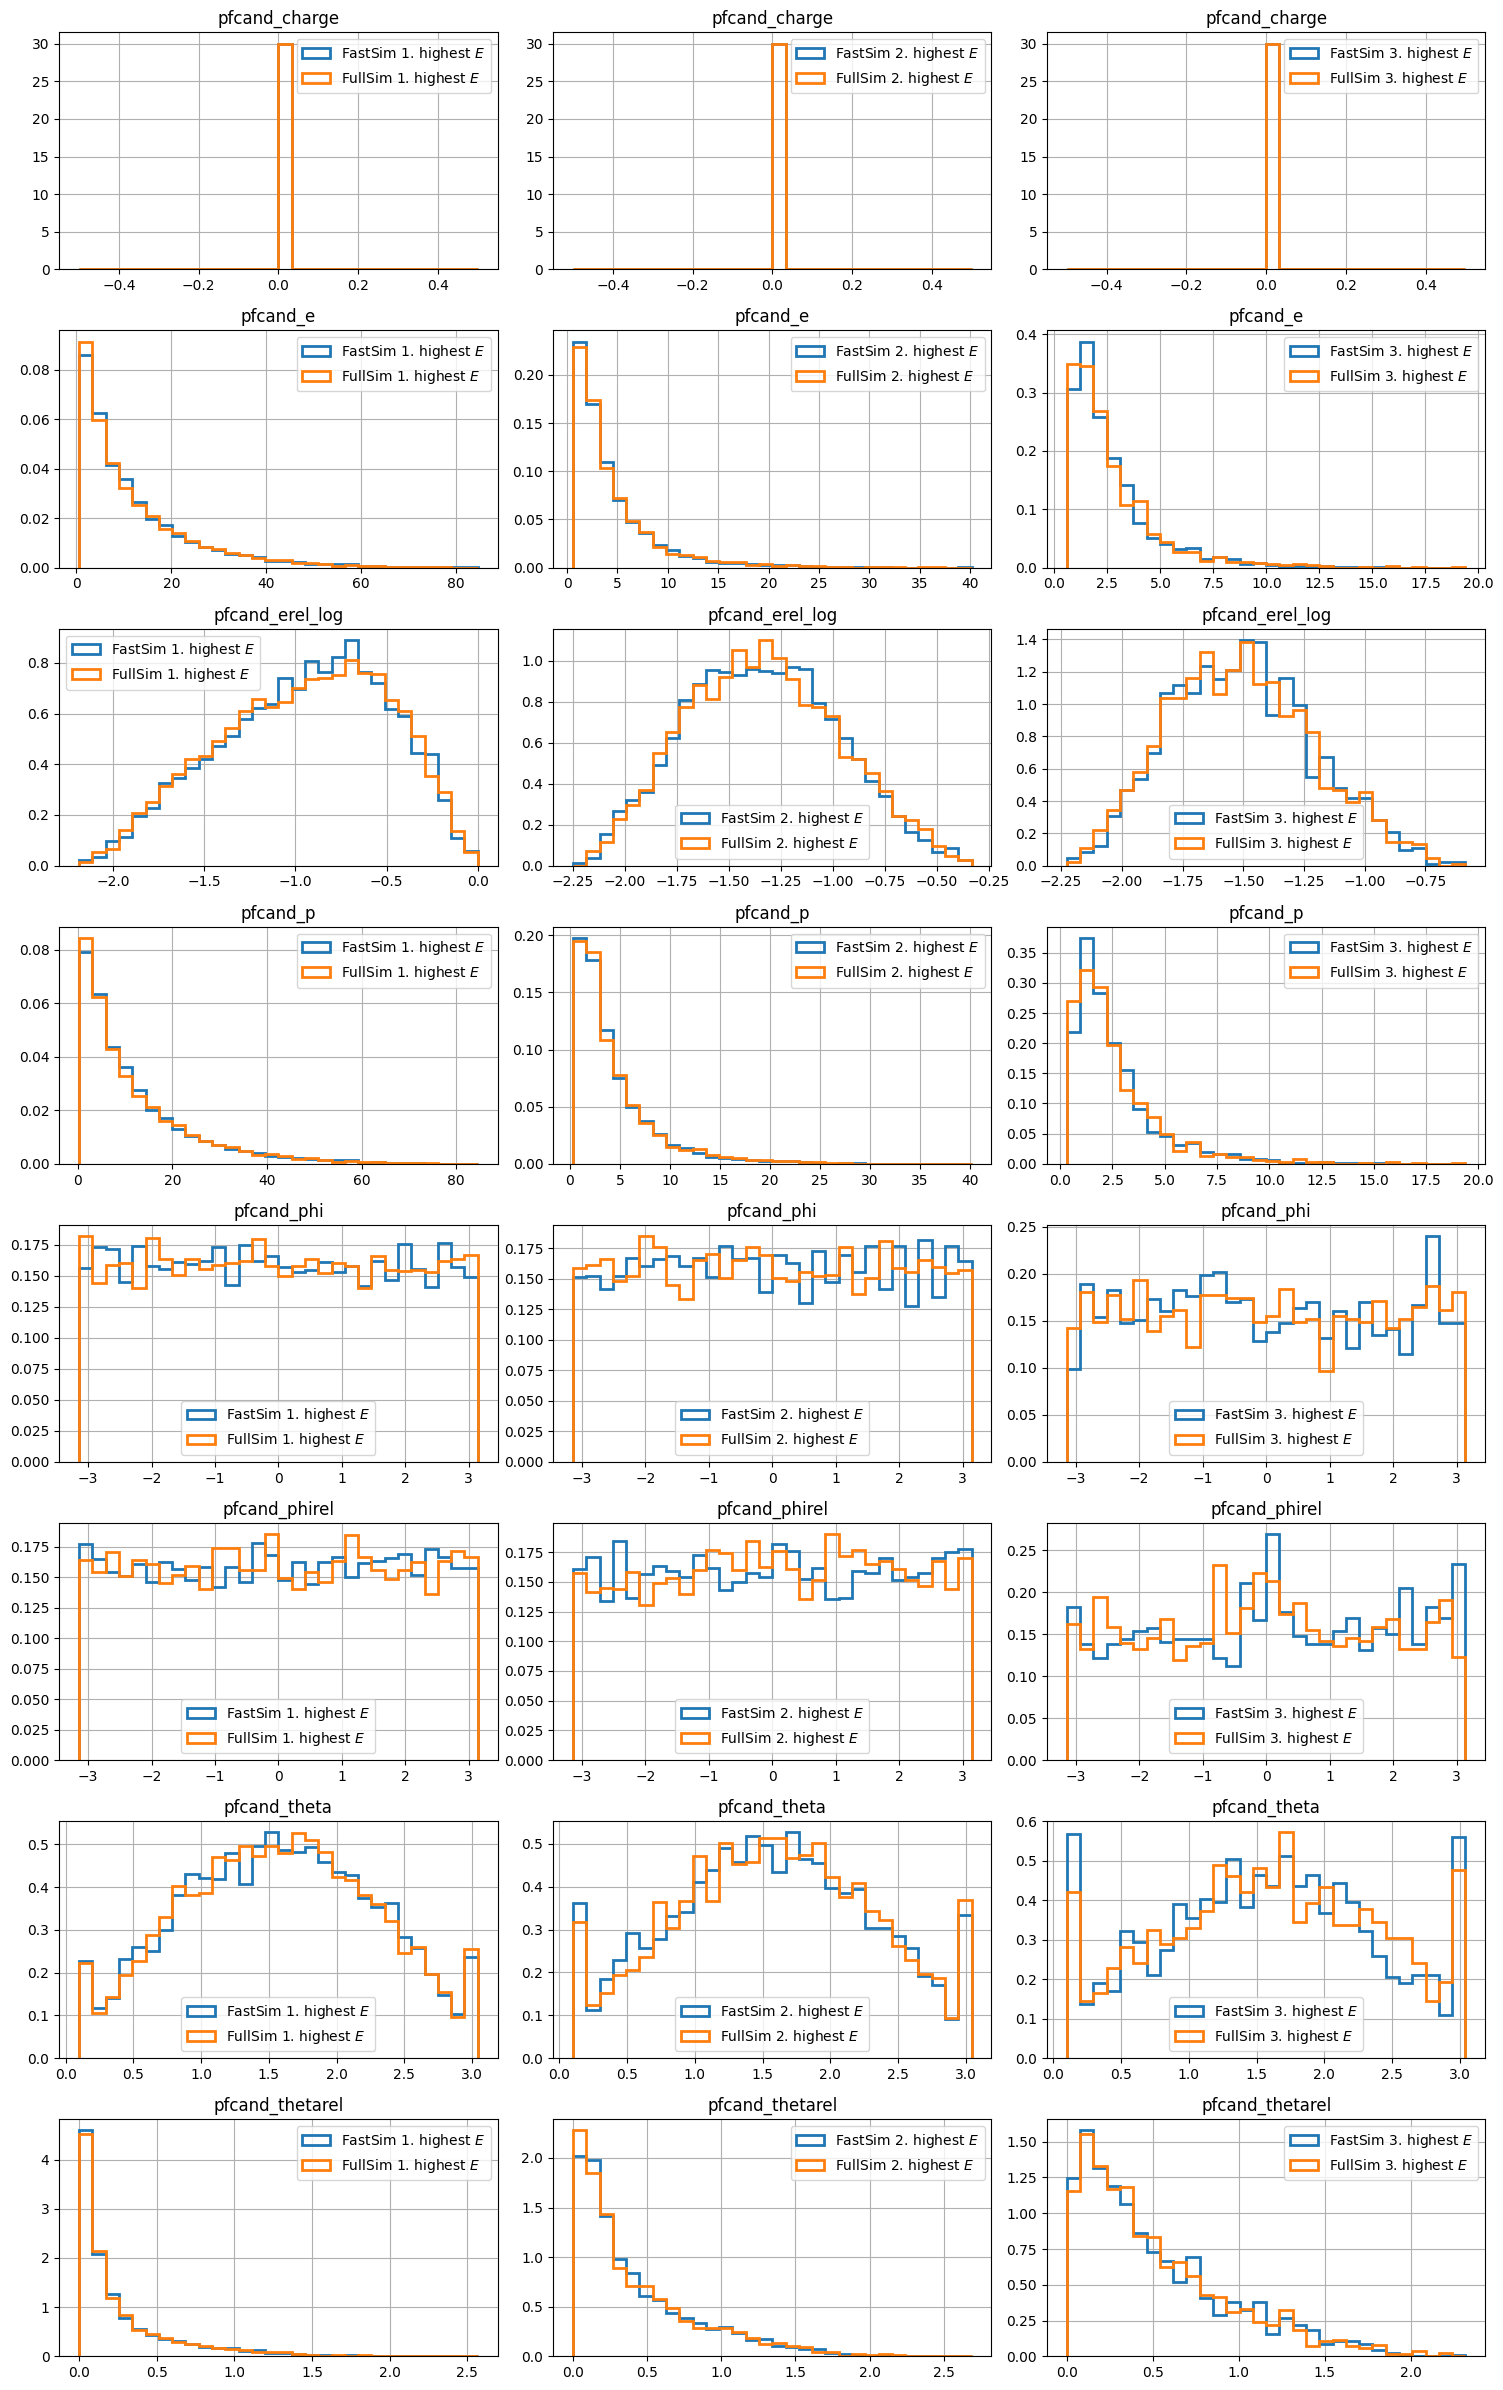

In [32]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

plot_key_highest_e_npart(keys, bins=30, save=save_status, path='./hist/jetct_gamma_properties.pdf')

## Why is relphi oszillating?

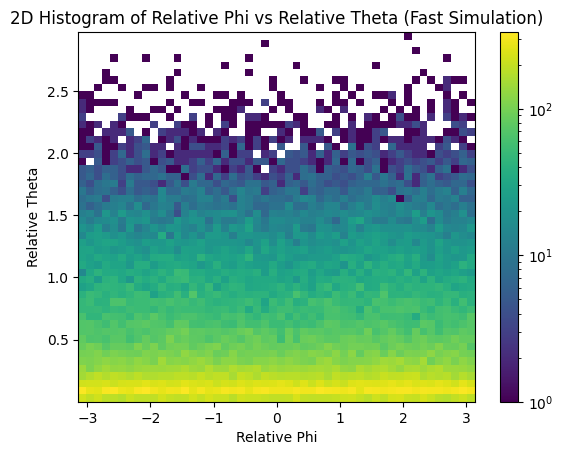

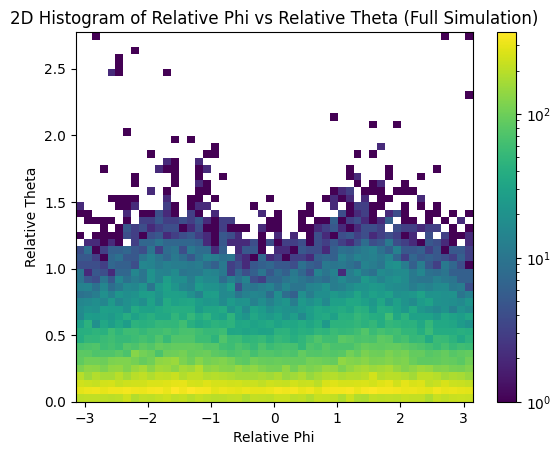

In [72]:
# 2d histogram of rel phi vs rel theta for fast and full sim 
from matplotlib.colors import LogNorm

# Extract the relevant variables from the dictionaries
rel_phi_fa = df_fa['pfcand_phirel']
rel_theta_fa = df_fa['pfcand_thetarel']

rel_phi_fu = df_fu['pfcand_phirel']
rel_theta_fu = df_fu['pfcand_thetarel']

# Plot the histogram for fast simulation
plt.hist2d(np.concatenate(rel_phi_fa), np.concatenate(rel_theta_fa), bins=50, cmap='viridis', norm=LogNorm())
plt.colorbar()
plt.xlabel('Relative Phi')
plt.ylabel('Relative Theta')
plt.title('2D Histogram of Relative Phi vs Relative Theta (Fast Simulation)')
plt.show()

# Plot the histogram for full simulation
plt.hist2d(np.concatenate(rel_phi_fu), np.concatenate(rel_theta_fu), bins=50, cmap='viridis', norm=LogNorm())
plt.colorbar()
plt.xlabel('Relative Phi')
plt.ylabel('Relative Theta')
plt.title('2D Histogram of Relative Phi vs Relative Theta (Full Simulation)')
plt.show()

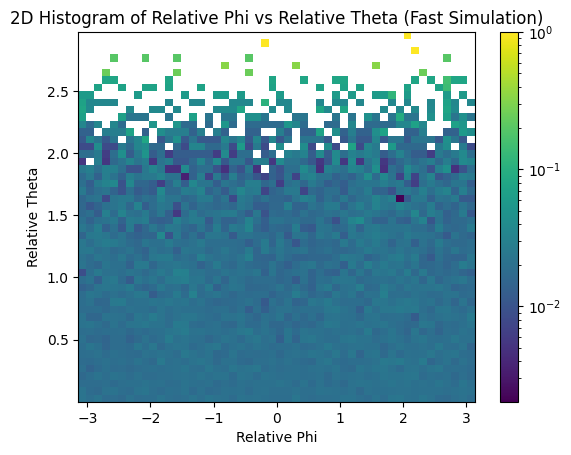

/tmp/ipykernel_902112/3209543124.py:15: RuntimeWarning: invalid value encountered in divide
  hist_norm = hist / hist.sum(axis=0, keepdims=True)  # Normalize over theta


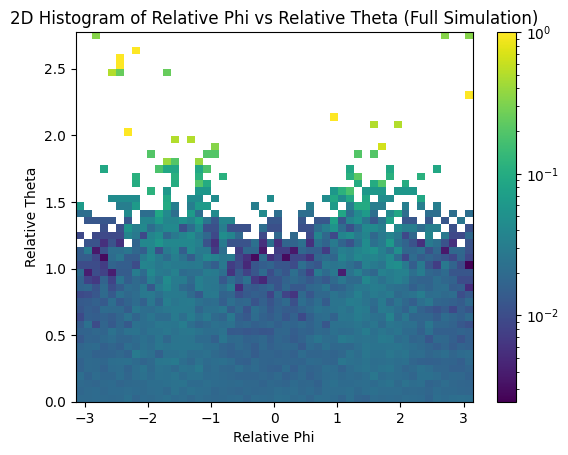

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Extract the relevant variables from the dictionaries
rel_phi_fa = df_fa['pfcand_phirel']
rel_theta_fa = df_fa['pfcand_thetarel']

rel_phi_fu = df_fu['pfcand_phirel']
rel_theta_fu = df_fu['pfcand_thetarel']

# Define a function to normalize histograms over theta
def normalize_hist2d_over_theta(phi, theta, bins=50):
    hist, xedges, yedges = np.histogram2d(phi, theta, bins=bins)
    hist_norm = hist / hist.sum(axis=0, keepdims=True)  # Normalize over theta
    return hist_norm, xedges, yedges

# Plot the histogram for fast simulation
hist_fa, xedges_fa, yedges_fa = normalize_hist2d_over_theta(np.concatenate(rel_phi_fa), np.concatenate(rel_theta_fa))
plt.imshow(hist_fa.T, origin='lower', aspect='auto', cmap='viridis', norm=LogNorm(),
           extent=[xedges_fa[0], xedges_fa[-1], yedges_fa[0], yedges_fa[-1]])
plt.colorbar()
plt.xlabel('Relative Phi')
plt.ylabel('Relative Theta')
plt.title('2D Histogram of Relative Phi vs Relative Theta (Fast Simulation)')
plt.show()

# Plot the histogram for full simulation
hist_fu, xedges_fu, yedges_fu = normalize_hist2d_over_theta(np.concatenate(rel_phi_fu), np.concatenate(rel_theta_fu))
plt.imshow(hist_fu.T, origin='lower', aspect='auto', cmap='viridis', norm=LogNorm(),
           extent=[xedges_fu[0], xedges_fu[-1], yedges_fu[0], yedges_fu[-1]])
plt.colorbar()
plt.xlabel('Relative Phi')
plt.ylabel('Relative Theta')
plt.title('2D Histogram of Relative Phi vs Relative Theta (Full Simulation)')
plt.show()


to-do list: 
- rel phi vs multiplicity in jet
- rel phi vs rel theta for leading charged (neutral) particle 

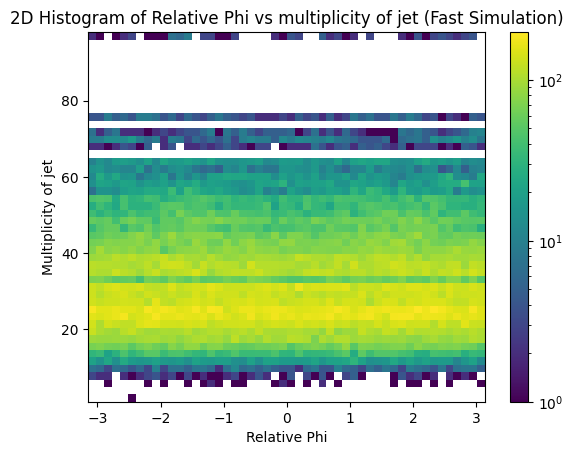

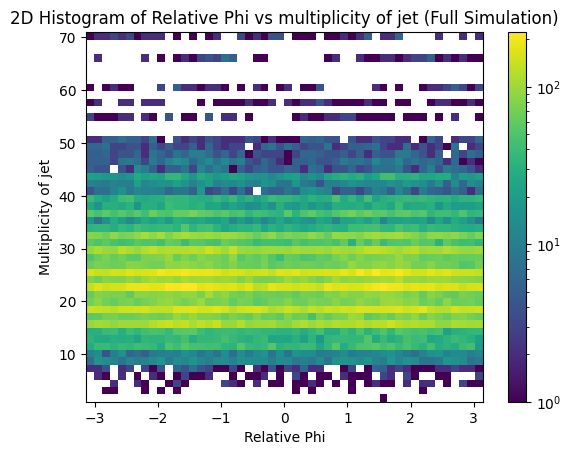

In [44]:
# 2d histogram of rel phi vs rel theta for fast and full sim 
from matplotlib.colors import LogNorm

# Extract the relevant variables from the dictionaries
rel_phi_fa = df_fa['pfcand_phirel']
multipl_fa = df_fa['jet_nconst']

len_fa = []
for a in rel_phi_fa:
    len_fa.append(len(a))
len_fa = np.array(len_fa)

rel_phi_fu = df_fu['pfcand_phirel']
multipl_fu = df_fu['jet_nconst']

len_fu = []
for a in rel_phi_fu:
    len_fu.append(len(a))
len_fu = np.array(len_fu)



# Plot the histogram for fast simulation
plt.hist2d(np.concatenate(rel_phi_fa), np.repeat(multipl_fa, len_fa), bins=50, cmap='viridis', norm=LogNorm())
plt.colorbar()
plt.xlabel('Relative Phi')
plt.ylabel('Multiplicity of jet')
plt.title('2D Histogram of Relative Phi vs multiplicity of jet (Fast Simulation)')
plt.show()

# Plot the histogram for full simulation
plt.hist2d(np.concatenate(rel_phi_fu), np.repeat(multipl_fu, len_fu), bins=50, cmap='viridis', norm=LogNorm())
plt.colorbar()
plt.xlabel('Relative Phi')
plt.ylabel('Multiplicity of jet')
plt.title('2D Histogram of Relative Phi vs multiplicity of jet (Full Simulation)')
plt.show()

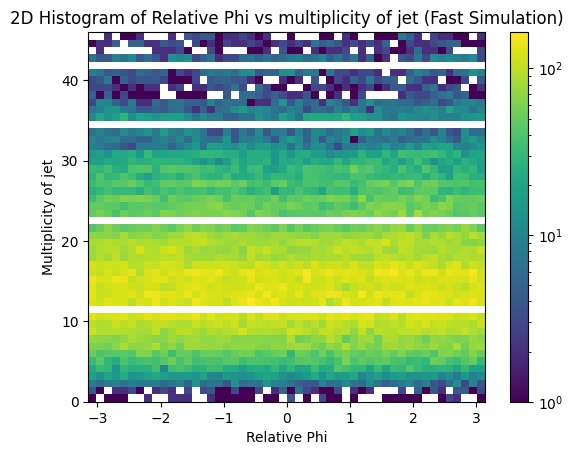

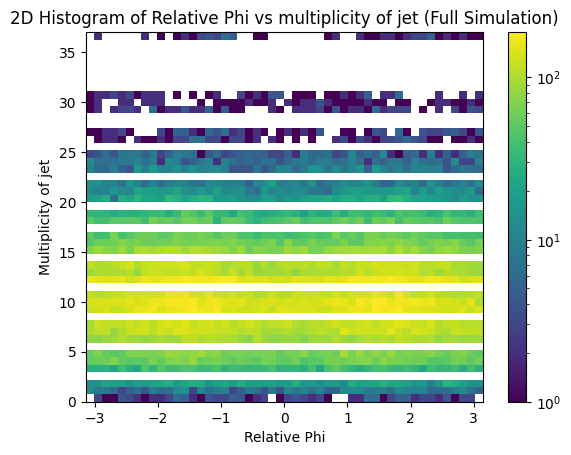

In [45]:
# 2d histogram of rel phi vs rel theta for fast and full sim 
from matplotlib.colors import LogNorm

# Extract the relevant variables from the dictionaries
rel_phi_fa = df_fa['pfcand_phirel']
multipl_fa = df_fa['jet_ngamma']

len_fa = []
for a in rel_phi_fa:
    len_fa.append(len(a))
len_fa = np.array(len_fa)

rel_phi_fu = df_fu['pfcand_phirel']
multipl_fu = df_fu['jet_ngamma']

len_fu = []
for a in rel_phi_fu:
    len_fu.append(len(a))
len_fu = np.array(len_fu)



# Plot the histogram for fast simulation
plt.hist2d(np.concatenate(rel_phi_fa), np.repeat(multipl_fa, len_fa), bins=50, cmap='viridis', norm=LogNorm())
plt.colorbar()
plt.xlabel('Relative Phi')
plt.ylabel('Multiplicity of jet')
plt.title('2D Histogram of Relative Phi vs multiplicity of jet (Fast Simulation)')
plt.show()

# Plot the histogram for full simulation
plt.hist2d(np.concatenate(rel_phi_fu), np.repeat(multipl_fu, len_fu), bins=50, cmap='viridis', norm=LogNorm())
plt.colorbar()
plt.xlabel('Relative Phi')
plt.ylabel('Multiplicity of jet')
plt.title('2D Histogram of Relative Phi vs multiplicity of jet (Full Simulation)')
plt.show()

/tmp/ipykernel_902112/1247273425.py:19: RuntimeWarning: invalid value encountered in divide
  hist_norm = hist / hist.sum(axis=0, keepdims=True)  # Normalize over multiplicity


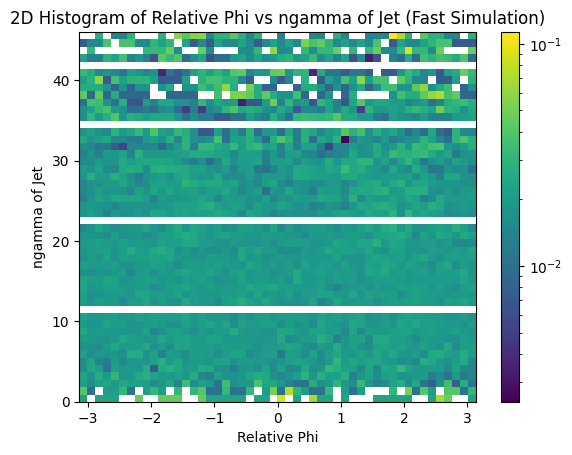

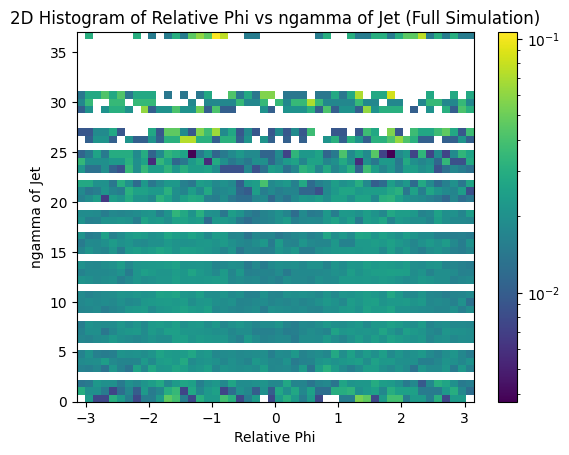

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Extract the relevant variables from the dictionaries
rel_phi_fa = df_fa['pfcand_phirel']
multipl_fa = df_fa['jet_ngamma']

rel_phi_fu = df_fu['pfcand_phirel']
multipl_fu = df_fu['jet_ngamma']

# Calculate lengths of the phi lists for fast and full simulations
len_fa = np.array([len(a) for a in rel_phi_fa])
len_fu = np.array([len(a) for a in rel_phi_fu])

# Define a function to normalize histograms over multiplicity
def normalize_hist2d_over_mult(phi, mult, len_arr, bins=50):
    hist, xedges, yedges = np.histogram2d(np.concatenate(phi), np.repeat(mult, len_arr), bins=bins)
    hist_norm = hist / hist.sum(axis=0, keepdims=True)  # Normalize over multiplicity
    return hist_norm, xedges, yedges

# Plot the histogram for fast simulation
hist_fa, xedges_fa, yedges_fa = normalize_hist2d_over_mult(rel_phi_fa, multipl_fa, len_fa)
plt.imshow(hist_fa.T, origin='lower', aspect='auto', cmap='viridis', norm=LogNorm(),
           extent=[xedges_fa[0], xedges_fa[-1], yedges_fa[0], yedges_fa[-1]])
plt.colorbar()
plt.xlabel('Relative Phi')
plt.ylabel('ngamma of Jet')
plt.title('2D Histogram of Relative Phi vs ngamma of Jet (Fast Simulation)')
plt.show()

# Plot the histogram for full simulation
hist_fu, xedges_fu, yedges_fu = normalize_hist2d_over_mult(rel_phi_fu, multipl_fu, len_fu)
plt.imshow(hist_fu.T, origin='lower', aspect='auto', cmap='viridis', norm=LogNorm(),
           extent=[xedges_fu[0], xedges_fu[-1], yedges_fu[0], yedges_fu[-1]])
plt.colorbar()
plt.xlabel('Relative Phi')
plt.ylabel('ngamma of Jet')
plt.title('2D Histogram of Relative Phi vs ngamma of Jet (Full Simulation)')
plt.show()


/tmp/ipykernel_902112/3084792997.py:19: RuntimeWarning: invalid value encountered in divide
  hist_norm = hist / hist.sum(axis=0, keepdims=True)  # Normalize over multiplicity


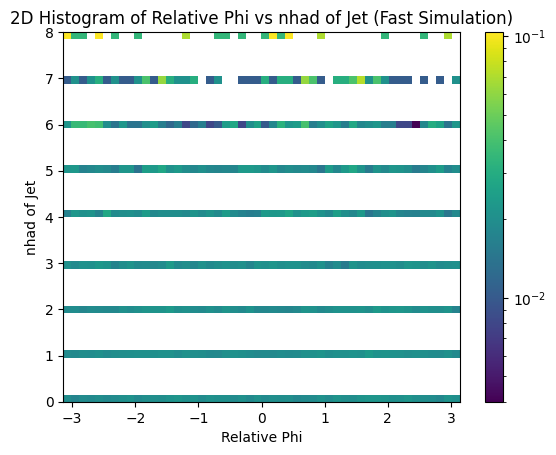

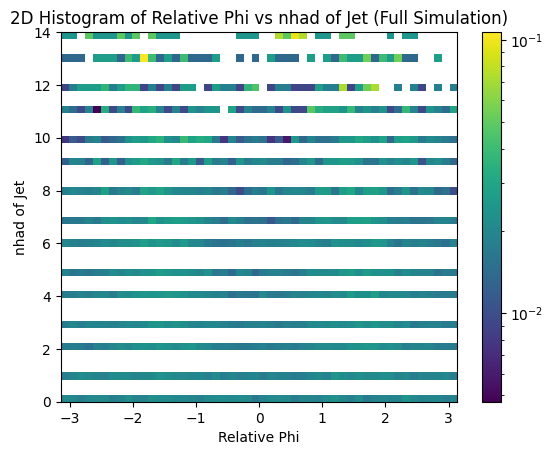

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Extract the relevant variables from the dictionaries
rel_phi_fa = df_fa['pfcand_phirel']
multipl_fa = df_fa['jet_nnhad']

rel_phi_fu = df_fu['pfcand_phirel']
multipl_fu = df_fu['jet_nnhad']

# Calculate lengths of the phi lists for fast and full simulations
len_fa = np.array([len(a) for a in rel_phi_fa])
len_fu = np.array([len(a) for a in rel_phi_fu])

# Define a function to normalize histograms over multiplicity
def normalize_hist2d_over_mult(phi, mult, len_arr, bins=50):
    hist, xedges, yedges = np.histogram2d(np.concatenate(phi), np.repeat(mult, len_arr), bins=bins)
    hist_norm = hist / hist.sum(axis=0, keepdims=True)  # Normalize over multiplicity
    return hist_norm, xedges, yedges

# Plot the histogram for fast simulation
hist_fa, xedges_fa, yedges_fa = normalize_hist2d_over_mult(rel_phi_fa, multipl_fa, len_fa)
plt.imshow(hist_fa.T, origin='lower', aspect='auto', cmap='viridis', norm=LogNorm(),
           extent=[xedges_fa[0], xedges_fa[-1], yedges_fa[0], yedges_fa[-1]])
plt.colorbar()
plt.xlabel('Relative Phi')
plt.ylabel('nhad of Jet')
plt.title('2D Histogram of Relative Phi vs nhad of Jet (Fast Simulation)')
plt.show()

# Plot the histogram for full simulation
hist_fu, xedges_fu, yedges_fu = normalize_hist2d_over_mult(rel_phi_fu, multipl_fu, len_fu)
plt.imshow(hist_fu.T, origin='lower', aspect='auto', cmap='viridis', norm=LogNorm(),
           extent=[xedges_fu[0], xedges_fu[-1], yedges_fu[0], yedges_fu[-1]])
plt.colorbar()
plt.xlabel('Relative Phi')
plt.ylabel('nhad of Jet')
plt.title('2D Histogram of Relative Phi vs nhad of Jet (Full Simulation)')
plt.show()


In [48]:
relphi_3lp_c_fa = get_chad_elements(df_fa["pfcand_phirel"], index_charged_3E_fa)
relphi_3lp_c_fu = get_chad_elements(df_fu["pfcand_phirel"], index_charged_3E_fu)

reltheta_3lp_c_fa = get_chad_elements(df_fa["pfcand_thetarel"], index_charged_3E_fa)
reltheta_3lp_c_fu = get_chad_elements(df_fu["pfcand_thetarel"], index_charged_3E_fu)

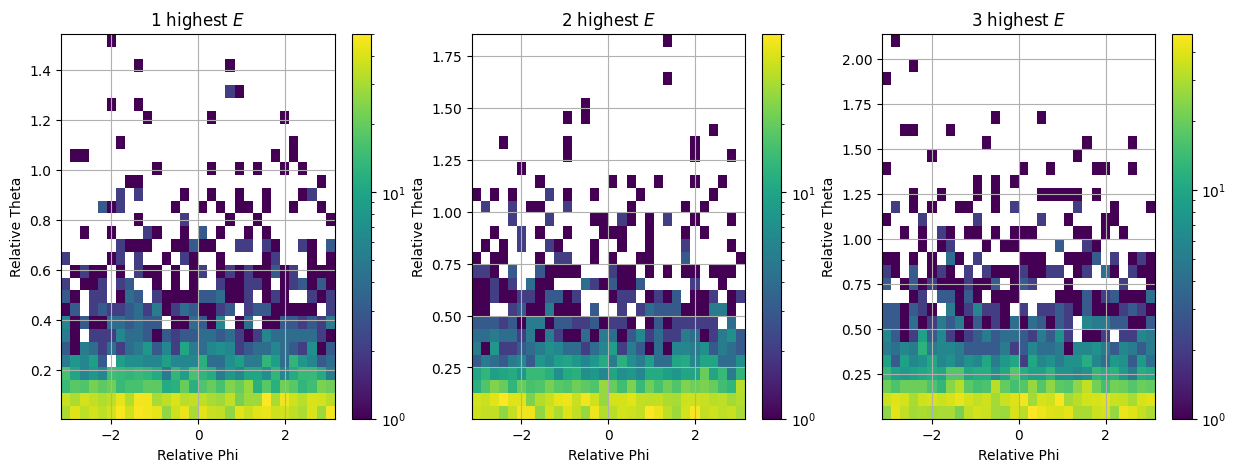

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    h = ax.hist2d(relphi_3lp_c_fa[i], reltheta_3lp_c_fa[i], bins=30, cmap='viridis', norm=LogNorm())
    fig.colorbar(h[3], ax=ax)  # h[3] is the QuadMesh object
    ax.set_xlabel('Relative Phi')
    ax.set_ylabel('Relative Theta')
    ax.set_title(f'{i+1} highest $E$')
    ax.grid()

plt.show()

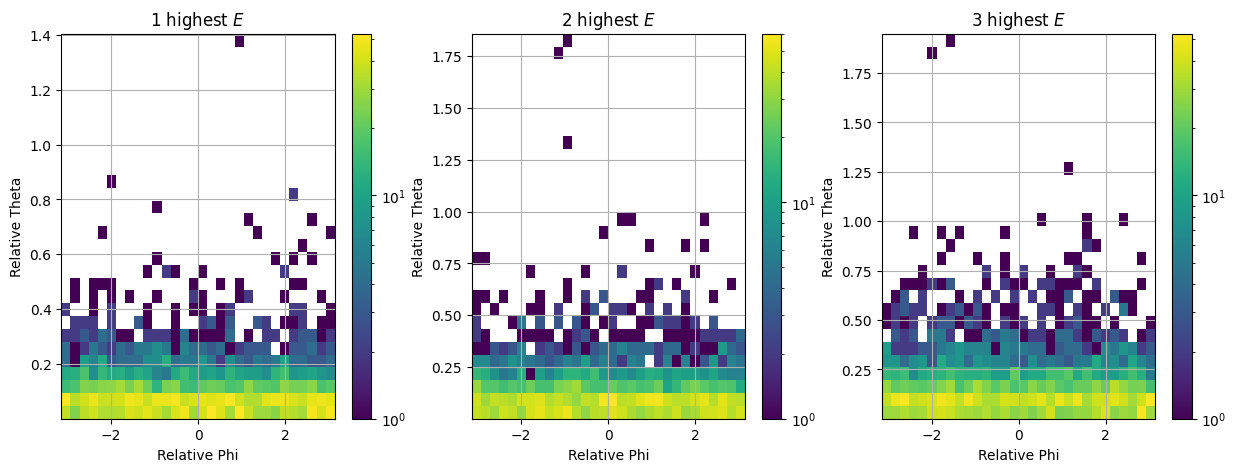

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    h = ax.hist2d(relphi_3lp_c_fu[i], reltheta_3lp_c_fu[i], bins=30, cmap='viridis', norm=LogNorm())
    fig.colorbar(h[3], ax=ax)  # h[3] is the QuadMesh object
    ax.set_xlabel('Relative Phi')
    ax.set_ylabel('Relative Theta')
    ax.set_title(f'{i+1} highest $E$')
    ax.grid()

plt.show()

/tmp/ipykernel_902112/3919919407.py:4: RuntimeWarning: invalid value encountered in divide
  hist_norm = hist / hist.sum(axis=0, keepdims=True)  # Normalize over theta


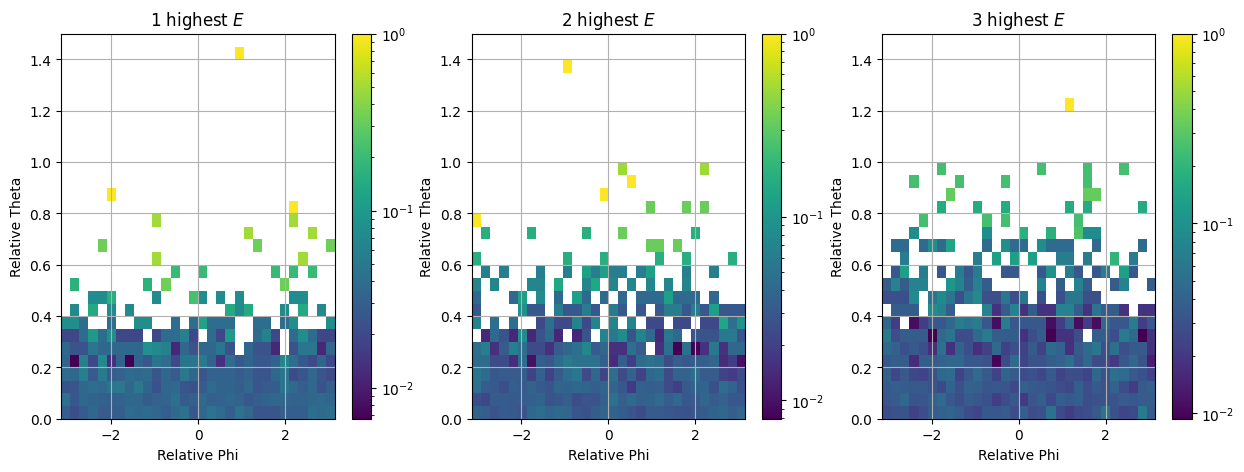

In [51]:
# Function to normalize histograms over theta
def normalize_hist2d_over_theta(phi, theta, bins=30, range=[[-np.pi, np.pi], [0, 1.5]]):
    hist, xedges, yedges = np.histogram2d(phi, theta, bins=bins, range=range)
    hist_norm = hist / hist.sum(axis=0, keepdims=True)  # Normalize over theta
    return hist_norm, xedges, yedges

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    # Normalize the histogram for each subplot
    hist_norm, xedges, yedges = normalize_hist2d_over_theta(relphi_3lp_c_fu[i], reltheta_3lp_c_fu[i])
    
    # Plot the normalized histogram
    im = ax.imshow(hist_norm.T, origin='lower', aspect='auto', cmap='viridis', norm=LogNorm(),
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('Relative Phi')
    ax.set_ylabel('Relative Theta')
    ax.set_title(f'{i+1} highest $E$')
    ax.grid()

plt.show()

In [76]:
relphi_3lp_n_fa = get_chad_elements(df_fa["pfcand_phirel"], index_neutral_3E_fa)
relphi_3lp_n_fu = get_chad_elements(df_fu["pfcand_phirel"], index_neutral_3E_fu)

reltheta_3lp_n_fa = get_chad_elements(df_fa["pfcand_thetarel"], index_neutral_3E_fa)
reltheta_3lp_n_fu = get_chad_elements(df_fu["pfcand_thetarel"], index_neutral_3E_fu)

theta_3lp_n_fa = get_chad_elements(df_fa["pfcand_theta"], index_neutral_3E_fa)
theta_3lp_n_fu = get_chad_elements(df_fu["pfcand_theta"], index_neutral_3E_fu)

/tmp/ipykernel_902112/925190710.py:4: RuntimeWarning: invalid value encountered in divide
  hist_norm = hist / hist.sum(axis=0, keepdims=True)  # Normalize over theta


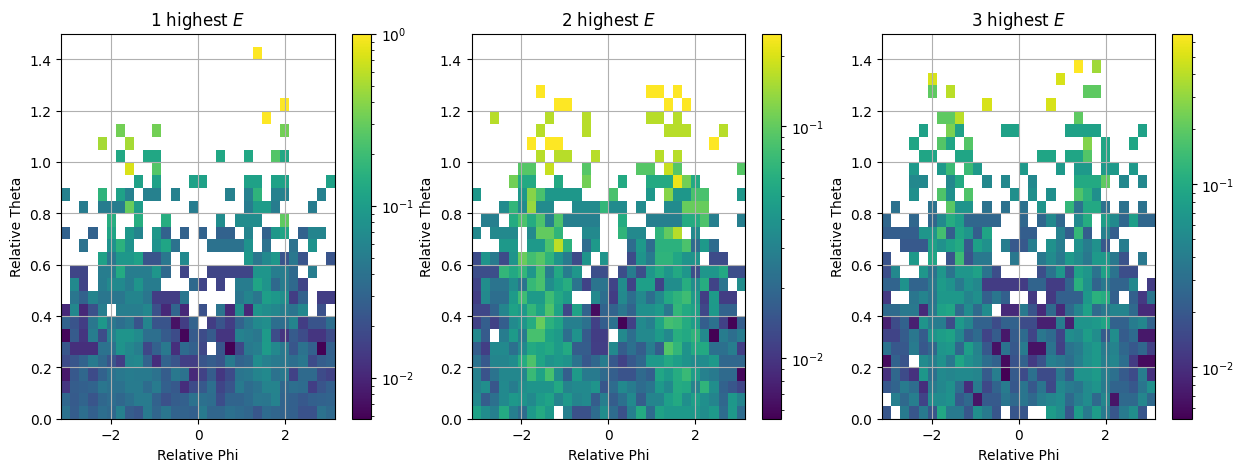

In [65]:
# Function to normalize histograms over theta
def normalize_hist2d_over_theta(phi, theta, bins=30, range=[[-np.pi, np.pi], [0, 1.5]]):
    hist, xedges, yedges = np.histogram2d(phi, theta, bins=bins, range=range)
    hist_norm = hist / hist.sum(axis=0, keepdims=True)  # Normalize over theta
    return hist_norm, xedges, yedges

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    # Normalize the histogram for each subplot
    hist_norm, xedges, yedges = normalize_hist2d_over_theta(relphi_3lp_n_fu[i], reltheta_3lp_n_fu[i])
    
    # Plot the normalized histogram
    im = ax.imshow(hist_norm.T, origin='lower', aspect='auto', cmap='viridis', norm=LogNorm(),
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('Relative Phi')
    ax.set_ylabel('Relative Theta')
    ax.set_title(f'{i+1} highest $E$')
    ax.grid()

plt.show()

Ok, this is interesting. Let's plot it next to each other.

/tmp/ipykernel_902112/925190710.py:4: RuntimeWarning: invalid value encountered in divide
  hist_norm = hist / hist.sum(axis=0, keepdims=True)  # Normalize over theta


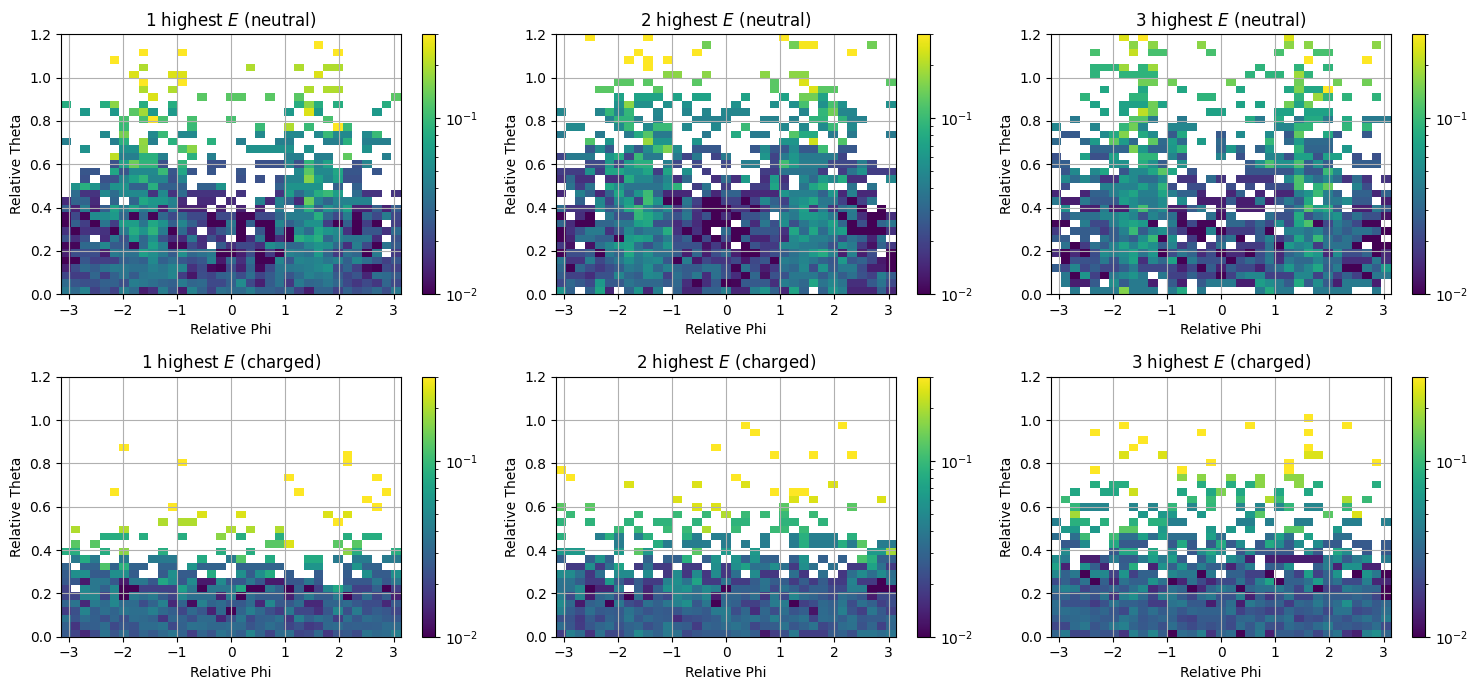

In [70]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

fig, axs = plt.subplots(2, 3, figsize=(15, 7))

for i, ax in enumerate(axs.flat):  # Use axs.flat to iterate over all axes in the 2D array
    if i in [0, 1, 2]:
        # Normalize the histogram for each subplot
        hist_norm, xedges, yedges = normalize_hist2d_over_theta(relphi_3lp_n_fu[i], reltheta_3lp_n_fu[i], range=[[-np.pi, np.pi], [0, 1.2]], bins=35)
        
        # Plot the normalized histogram
        im = ax.imshow(hist_norm.T, origin='lower', aspect='auto', cmap='viridis', norm=LogNorm(vmin=1e-2, vmax=.3),
                       extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
        fig.colorbar(im, ax=ax)
        ax.set_title(f'{i+1} highest $E$ (neutral)')
    elif i in [3, 4, 5]:
        # Normalize the histogram for each subplot
        hist_norm, xedges, yedges = normalize_hist2d_over_theta(relphi_3lp_c_fu[i-3], reltheta_3lp_c_fu[i-3],  range=[[-np.pi, np.pi], [0, 1.2]], bins=35)  # Note the index correction
        
        # Plot the normalized histogram
        im = ax.imshow(hist_norm.T, origin='lower', aspect='auto', cmap='viridis', norm=LogNorm(vmin=1e-2, vmax=.3),
                       extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
        fig.colorbar(im, ax=ax)
        ax.set_title(f'{i-2} highest $E$ (charged)')
        
    ax.set_xlabel('Relative Phi')
    ax.set_ylabel('Relative Theta')
    ax.grid()
plt.tight_layout()
plt.show()


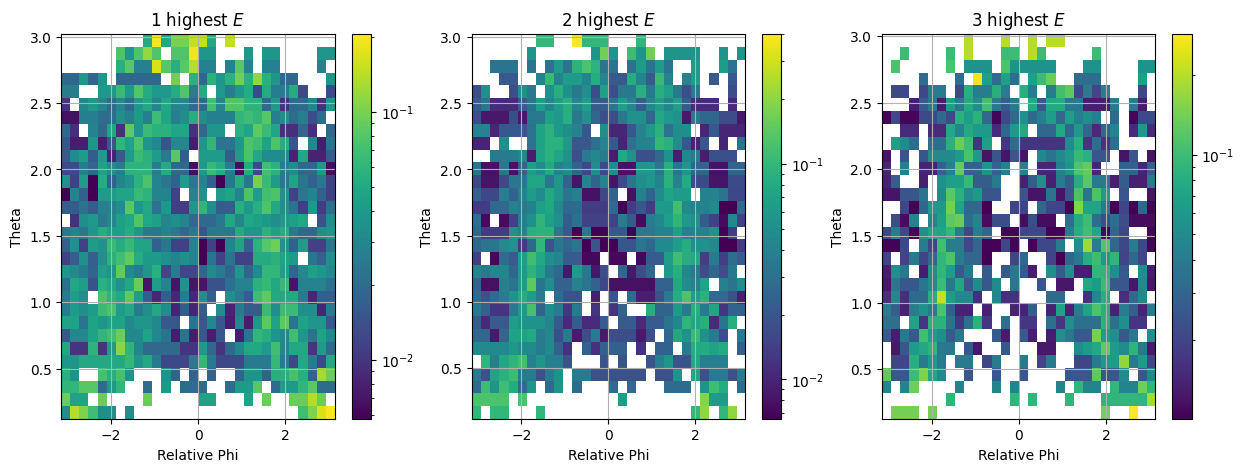

In [79]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    # Normalize the histogram for each subplot
    hist_norm, xedges, yedges = normalize_hist2d_over_theta(relphi_3lp_n_fu[i], theta_3lp_n_fu[i], bins=30)
    
    # Plot the normalized histogram
    im = ax.imshow(hist_norm.T, origin='lower', aspect='auto', cmap='viridis', norm=LogNorm(),
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('Relative Phi')
    ax.set_ylabel('Theta')
    ax.set_title(f'{i+1} highest $E$')
    ax.grid()

plt.show()

(array([ 7., 11., 22., 40., 49., 79., 77., 58., 72., 62., 80., 77., 99.,
        96., 96., 89., 99., 82., 74., 70., 82., 59., 66., 93., 77., 48.,
        30., 18., 10.,  5.]),
 array([0.1289576 , 0.2252541 , 0.32155061, 0.41784713, 0.51414365,
        0.61044014, 0.70673662, 0.80303311, 0.89932966, 0.99562615,
        1.09192264, 1.18821919, 1.28451562, 1.38081217, 1.47710872,
        1.57340515, 1.6697017 , 1.76599824, 1.86229467, 1.95859122,
        2.05488777, 2.15118432, 2.24748063, 2.34377718, 2.44007373,
        2.53637028, 2.63266683, 2.72896338, 2.82525969, 2.92155623,
        3.01785278]),
 <BarContainer object of 30 artists>)

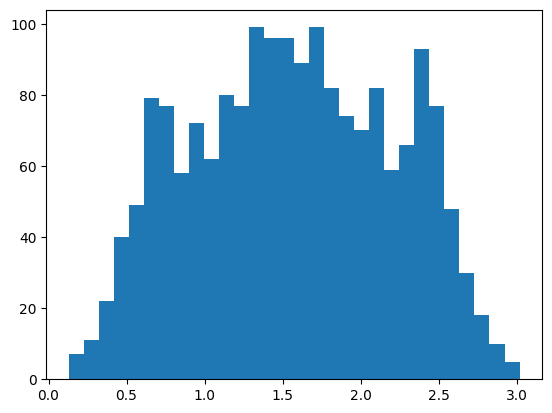

In [81]:
plt.hist(theta_3lp_n_fu[2], bins=30)